In [1]:
from time import time
import hydra
from omegaconf import DictConfig, OmegaConf
import numpy as np
import torch
import pypolo
import gpytorch
from pypolo.scalers import MinMaxScaler, StandardScaler
import yaml
from PIL import Image



In [2]:

def set_random_seed(seed):
    rng = np.random.RandomState(seed)
    torch.manual_seed(seed)
    print(f"Set random seed to {seed} in numpy and torch.")
    return rng


def get_environment(cfg, filepath="./data/n44w111.npz"):
    with np.load(filepath) as data:
        env = data["arr_0"]
    print(f"Loaded environment of shape {env.shape}.")
    return env


def get_environment_from_image(cfg, png_path, resize=None, max_height=None):
    
    image = Image.open(png_path)

    if resize is not None:
        if not isinstance(resize, tuple):
            raise TypeError
        else:
            resized_image = image.resize(resize, Image.BOX)
            image = resized_image.convert('L') 
    
    env = np.array(image)
    
    if max_height is not None:
        
        if not isinstance(max_height, float):
            raise TypeError
        else:
            min_value = np.min(env)
            max_value = np.max(env)
            normalized_matrix = (env - min_value) / (max_value - min_value)
            env = normalized_matrix * max_height
            
    print(f"Loaded environment of shape {env.shape}.")
    return env


def get_sensor(cfg, env, rng):
    
    sensor = pypolo.sensors.LidarSensor(
        matrix=env,
        env_extent=cfg.env_extent,
        rate=cfg.sensing_rate,
        noise_scale=cfg.noise_scale,
        rng=rng,
        max_distance = 3, #https://community.robotshop.com/blog/show/lidar-light-amp-laser-based-distance-sensors
        perception_angle=90,
    )
    
    print(
        f"Initialized sensor with rate {cfg.sensing_rate} and noise scale {cfg.noise_scale}."
    )
    return sensor


def get_robot(cfg, sensor, start, heading_start=0):
    
    robot = pypolo.robots.DigitRobot(
        sensor=sensor,
        start= np.append(start, heading_start),
        control_rate=cfg.control_rate,
        max_lin_vel=cfg.max_lin_vel,
        max_ang_vel=cfg.max_ang_vel,
        goal_radius=cfg.goal_radius,
    )
    
    # robot = pypolo.robots.DiffDriveRobot(
    #     sensor=sensor,
    #     state=np.array([cfg.task_extent[1], cfg.task_extent[2], -np.pi]),
    #     control_rate=cfg.control_rate,
    #     max_lin_vel=cfg.max_lin_vel,
    #     max_ang_vel=cfg.max_ang_vel,
    #     goal_radius=cfg.goal_radius,
    # )
    print(f"Initialized robot with control rate {cfg.control_rate}.")
    return robot


def get_visualizer(cfg, env):
    visualizer = pypolo.utils.Visualizer(
        cfg.env_extent, cfg.task_extent, cfg.plot_robot_interval
    )
    vmin, vmax = np.min(env), np.max(env)
    visualizer.vmins[1], visualizer.vmaxs[1] = vmin, vmax
    visualizer.plot_image(
        index=0, matrix=env, title="Ground Truth", vmin=vmin, vmax=vmax
    )
    print(f"Initialized visualizer.")
    return visualizer


def pilot_survey(cfg, sensor, rng):
    
    # Use DiffDriveRobot to survey around the terrain
    
    # bezier_planner = pypolo.planners.BezierPlanner(cfg.task_extent, rng)
    # goals = bezier_planner.plan(num_points=cfg.num_bezier_points)
    # robot.goals = goals
    
    # while len(robot.goals) > 0:
    #     robot.step_with_heading(current_heading=robot.state[2], num_targets = 3)
    #     # heading_c = np.arctan2(robot.state[1] - prev_state[1], robot.state[0] - prev_state[0])
    #     # prev_state = robot.state[:2]
        
    # x_init, y_init = robot.commit_samples()
    
    #-------------------------------------------------------------------
    
    #Grid-wise Sample
    x_min, x_max, y_min, y_max = cfg.task_extent
    x_grid = np.linspace(x_min, x_max, 10)
    y_grid = np.linspace(y_min, y_max, 10)
    xx, yy = np.meshgrid(x_grid, y_grid)
    x_init = np.column_stack((xx.flatten(), yy.flatten()))
    y_init = sensor.get(x_init[:, 0], x_init[:, 1]).reshape(-1, 1)
    
    #-------------------------------------------------------------------
    
    print(f"Collected {len(x_init)} samples in pilot survey.")

    return x_init, y_init


def get_model(cfg, x_init, y_init, x_scaler, y_scaler):
    if cfg.kernel.name == "RBF":
        kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        kernel.base_kernel.lengthscale = cfg.kernel.lengthscale
        kernel.outputscale = cfg.kernel.outputscale
    elif cfg.kernel.name == "AK":
        kernel = gpytorch.kernels.ScaleKernel(
            pypolo.models.gp.kernels.AttentiveKernel(
                dim_input=x_init.shape[1],
                dim_hidden=cfg.kernel.dim_hidden,
                dim_output=cfg.kernel.dim_output,
                min_lengthscale=cfg.kernel.min_lengthscale,
                max_lengthscale=cfg.kernel.max_lengthscale,
            )
        )
    else:
        raise ValueError(f"Unknown kernel: {cfg.kernel}")
    if cfg.model.name == "GPR":
        model = pypolo.models.gp.GPRModel(
            x_train=x_init,
            y_train=y_init,
            x_scalar=x_scaler,
            y_scalar=y_scaler,
            kernel=kernel,
            noise_var=cfg.model.noise_var,
            num_sparsification=cfg.model.num_sparsification,
        )
    else:
        raise ValueError(f"Unknown model: {cfg.model.name}")
    print(f"Initialized model {cfg.model.name} with kernel {cfg.kernel.name}.")
    return model


def get_planner(cfg, rng, start, goal, obstacles=None, step_len=0.1, goal_sample_rate=0.6, search_radius=0.6, iter_max=10000, max_turn_angle=np.deg2rad(10)):
    
    if cfg.planner.name == "MaxEntropy":
        planner = pypolo.planners.MaxEntropyPlanner(
            cfg.task_extent, rng, cfg.planner.num_candidates
        )        
    elif cfg.planner.name == "LocalRRTStar":
        start = tuple(start)
        goal = tuple(goal)
        planner = pypolo.planners.LocalRRTStar(
            cfg.task_extent, rng, start, goal, step_len=step_len, goal_sample_rate=goal_sample_rate, search_radius=search_radius, iter_max=iter_max, max_turn_angle=max_turn_angle
        )
        
    else:
        raise ValueError(f"Unknown planner: {cfg.planner.name}")
    print(f"Initialized planner {cfg.planner.name}.")
    return planner


def model_update(num_steps, model, evaluator):
    # print("Optimization...")
    start = time()
    losses = model.optimize(num_steps=num_steps) #calculate lossses
    end = time()
    evaluator.training_times.append(end - start)
    evaluator.losses.extend(losses)


def evaluation(model, evaluator):
    # print(f"Prediction...")
    start = time()
    mean, std = model.predict(evaluator.eval_inputs)
    end = time()
    evaluator.prediction_times.append(end - start)
    evaluator.compute_metrics(mean, std)


def visualization(visualizer, evaluator, x_inducing=None):
    # print(f"Visualization...")
    visualizer.plot_prediction(evaluator.mean, evaluator.std, evaluator.abs_error)
    visualizer.plot_data(evaluator.x_train)
    if x_inducing is not None:
        print("Plotting inducing inputs...")
        visualizer.plot_inducing_inputs(x_inducing)
    visualizer.plot_metrics(evaluator)
    
    
def information_gathering(model, robot, planner, num_step=1, samples_per_dt=10, visualizer=None):
    print("Run information_gathering")
    
    #Final local goal
    final_goal = np.array([planner.s_goal.x , planner.s_goal.y])
    
    iters = 0
    
    while iters < num_step and (np.linalg.norm([final_goal[0] - robot.wp_c_x, final_goal[1] - robot.wp_c_y]) > planner.goal_radius):
    
        robot.goals = np.atleast_2d([robot.wp_n_x, robot.wp_n_y]) #next waypoint
        print("goal:", robot.goals)
        
        visualizer.plot_goal(robot.goals, final_goal)        
        visualizer.pause()
        plot_counter = 0
        
        while robot.has_goals:
            
            print("state: " ,robot.state)
            plot_counter += 1
            
            robot.step(model, num_targets = samples_per_dt)
                        
            if visualizer.interval > 0 and plot_counter % visualizer.interval == 0:
                visualizer.plot_robot(robot.state)
                visualizer.pause()
                
        iters += 1
        
    if len(robot.sampled_observations) > 0:

        x_new, y_new = robot.commit_samples()
        print("End information_gathering")
        return x_new, y_new


# def information_gathering(model, robot, planner, num_step=1, samples_per_dt=10, visualizer=None):
    
#     print("Run information_gathering")
    
#     final_goal = planner.goal
    
#     while True:

#         goal = planner.get_next_goal(robot, num_step)
#         print("goal:", goal)
#         # print("path", planner.path)
#         # print("current", (robot.wp_c_x, robot.wp_c_y))
    
#         visualizer.plot_goal(goal, final_goal)
#         robot.goals = goal
        
#         # print("Desired goal from planner.plan(): " ,robot.goals)
        
#         visualizer.pause()
#         plot_counter = 0
        
#         print("Sampling...")
#         while robot.has_goals:
            
#             print("state: " ,robot.state)
#             plot_counter += 1
            
#             # robot.step()
            
#             robot.step(model, num_targets = samples_per_dt)
                        
#             if visualizer.interval > 0 and plot_counter % visualizer.interval == 0:
#                 visualizer.plot_robot(robot.state)
#                 visualizer.pause()
#         if len(robot.sampled_observations) > 0:
#             # print("Append Sample Elevation: ", robot.sampled_observations)
#             # print("corresponding Sample Location: ", robot.sampled_locations)
#             x_new, y_new = robot.commit_samples()
#             print("End information_gathering")
#             return x_new, y_new

In [3]:
class Struct(object):
    def __init__(self, d):
        for k, v in d.items():
            
            k = k.replace("-","_")
            
            #Setting default configuration
            if k == 'defaults':
                parsed_list = eval(str(v))
                
                for item in parsed_list:
                    if isinstance(item, dict):
                        for key, value in item.items():
                            if key == '_self_':
                                pass
                            elif key == 'model':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            elif key == 'planner':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            elif key == 'kernel':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            else:
                                setattr(self, key.replace("/", "_").replace(" ","_"), Struct(value) if isinstance(value, dict) else value)
                            
            else:
                
                #Add other struct argument
                if isinstance(k, (list, tuple)):
                    setattr(self, k, [Struct(x) if isinstance(x, dict) else x for x in v])
                else:
                    setattr(self, k, Struct(v) if isinstance(v, dict) else v)
                
            
                

with open('./configs/main.yaml') as info:
    args = yaml.load(info)
    
print(args)
cfg = Struct(args)

{'seed': 0, 'env_extent': [-11.0, 11.0, -11.0, 11.0], 'task_extent': [-10.0, 10.0, -10.0, 10.0], 'eval_grid': [30, 30], 'sensing_rate': 0.5, 'noise_scale': 1.0, 'control_rate': 10.0, 'max_lin_vel': 0.5, 'max_ang_vel': 1.0, 'goal_radius': 0.1, 'num_bezier_points': 50, 'num_train_steps': 10, 'max_num_samples': 800, 'plot_robot_interval': 10, 'defaults': [{'model': 'gpr'}, {'kernel': 'ak'}, {'planner': 'max_entropy'}, {'override hydra/hydra_logging': 'disabled'}, {'override hydra/job_logging': 'disabled'}, '_self_'], 'hydra': {'output_subdir': None, 'run': {'dir': '.'}}}


In [4]:
env_path = '/home/kmuenpra/Desktop/terrains/terrain_n38_w087_1arc_v2.png'
# env_path = '/home/kmuenpra/Desktop/terrains/Mars_Terrain.jpg'

rng = set_random_seed(cfg.seed)
max_height = 0.5
env = get_environment_from_image(cfg, png_path=env_path, resize=(50,50), max_height=max_height)


Set random seed to 0 in numpy and torch.
Loaded environment of shape (50, 50).


In [5]:
#Update few configurations

cfg.noise_scale = 0.1 * max_height
cfg.planner.name = "LocalRRTStar"
cfg.task_extent = [cfg.env_extent[0] + 1, cfg.env_extent[1] - 1, cfg.env_extent[2] + 1, cfg.env_extent[3] - 1 ]

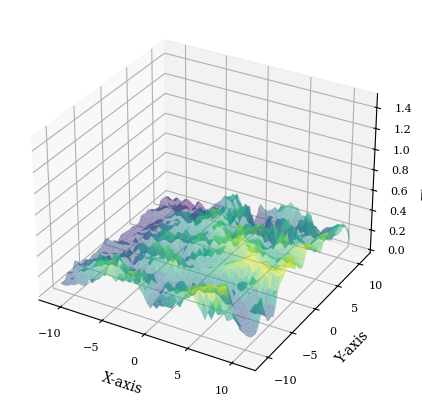

In [6]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.interpolate import griddata
# from scipy.ndimage import gaussian_filter
    

# # Create a meshgrid for X and Y coordinates
xi = np.linspace(cfg.env_extent[0] , cfg.env_extent[1], env.shape[0])
yi = np.linspace(cfg.env_extent[2], cfg.env_extent[3], env.shape[1])
X, Y = np.meshgrid(xi, yi)

# Create a 3D plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the interpolated surface
# ax.plot_surface(xnew, ynew, znew, cmap='viridis', alpha=0.5, label='Interpolated Surface')
ax.plot_surface(X,Y,env,cmap='viridis', alpha=0.5)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Elevation')
ax.set_zlim([0, 1.5])

plt.show()

In [7]:
#Setup sensors with noise, and set the environement coordinate to the env_extent
sensor =  get_sensor(cfg, env, rng)
sensor.matrix

Initialized sensor with rate 0.5 and noise scale 0.05.


array([[0.1092233 , 0.09466019, 0.10436893, ..., 0.22330097, 0.17475728,
        0.16747573],
       [0.09951456, 0.09708738, 0.15291262, ..., 0.16262136, 0.16504854,
        0.14563107],
       [0.10436893, 0.12378641, 0.12378641, ..., 0.1407767 , 0.1407767 ,
        0.13834951],
       ...,
       [0.0631068 , 0.06796117, 0.04854369, ..., 0.28398058, 0.28398058,
        0.29126214],
       [0.02669903, 0.02912621, 0.07038835, ..., 0.27427184, 0.26699029,
        0.23786408],
       [0.00728155, 0.        , 0.04368932, ..., 0.27912621, 0.20631068,
        0.09466019]])

Initialized visualizer.


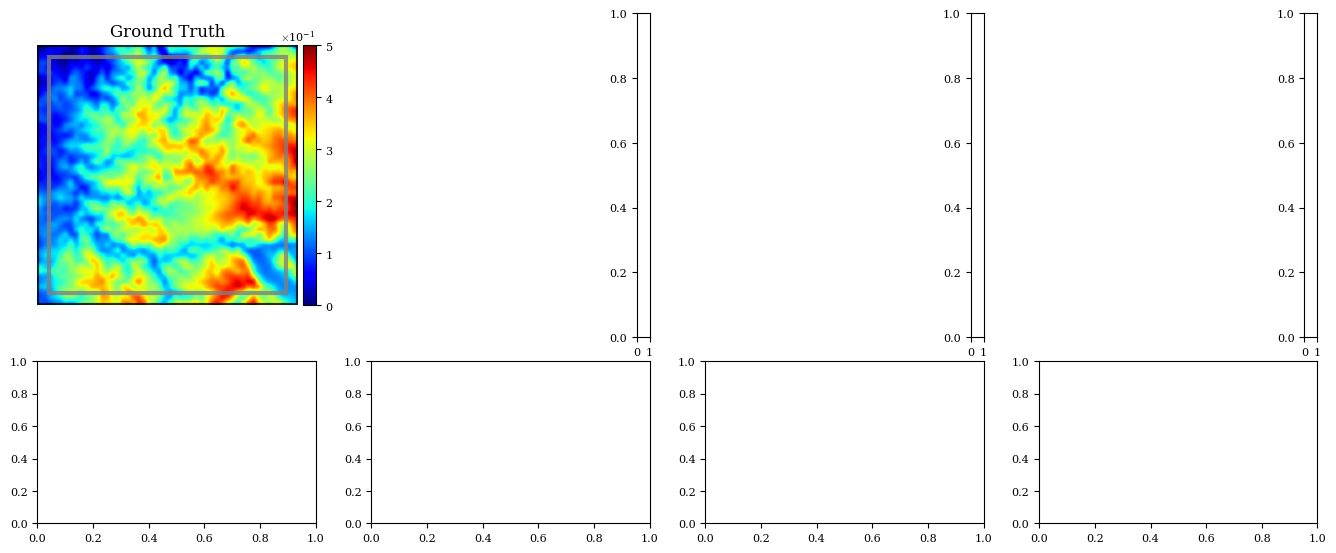

In [8]:
#Define visualizer
visualizer = get_visualizer(cfg, env)

### Global Planner

0


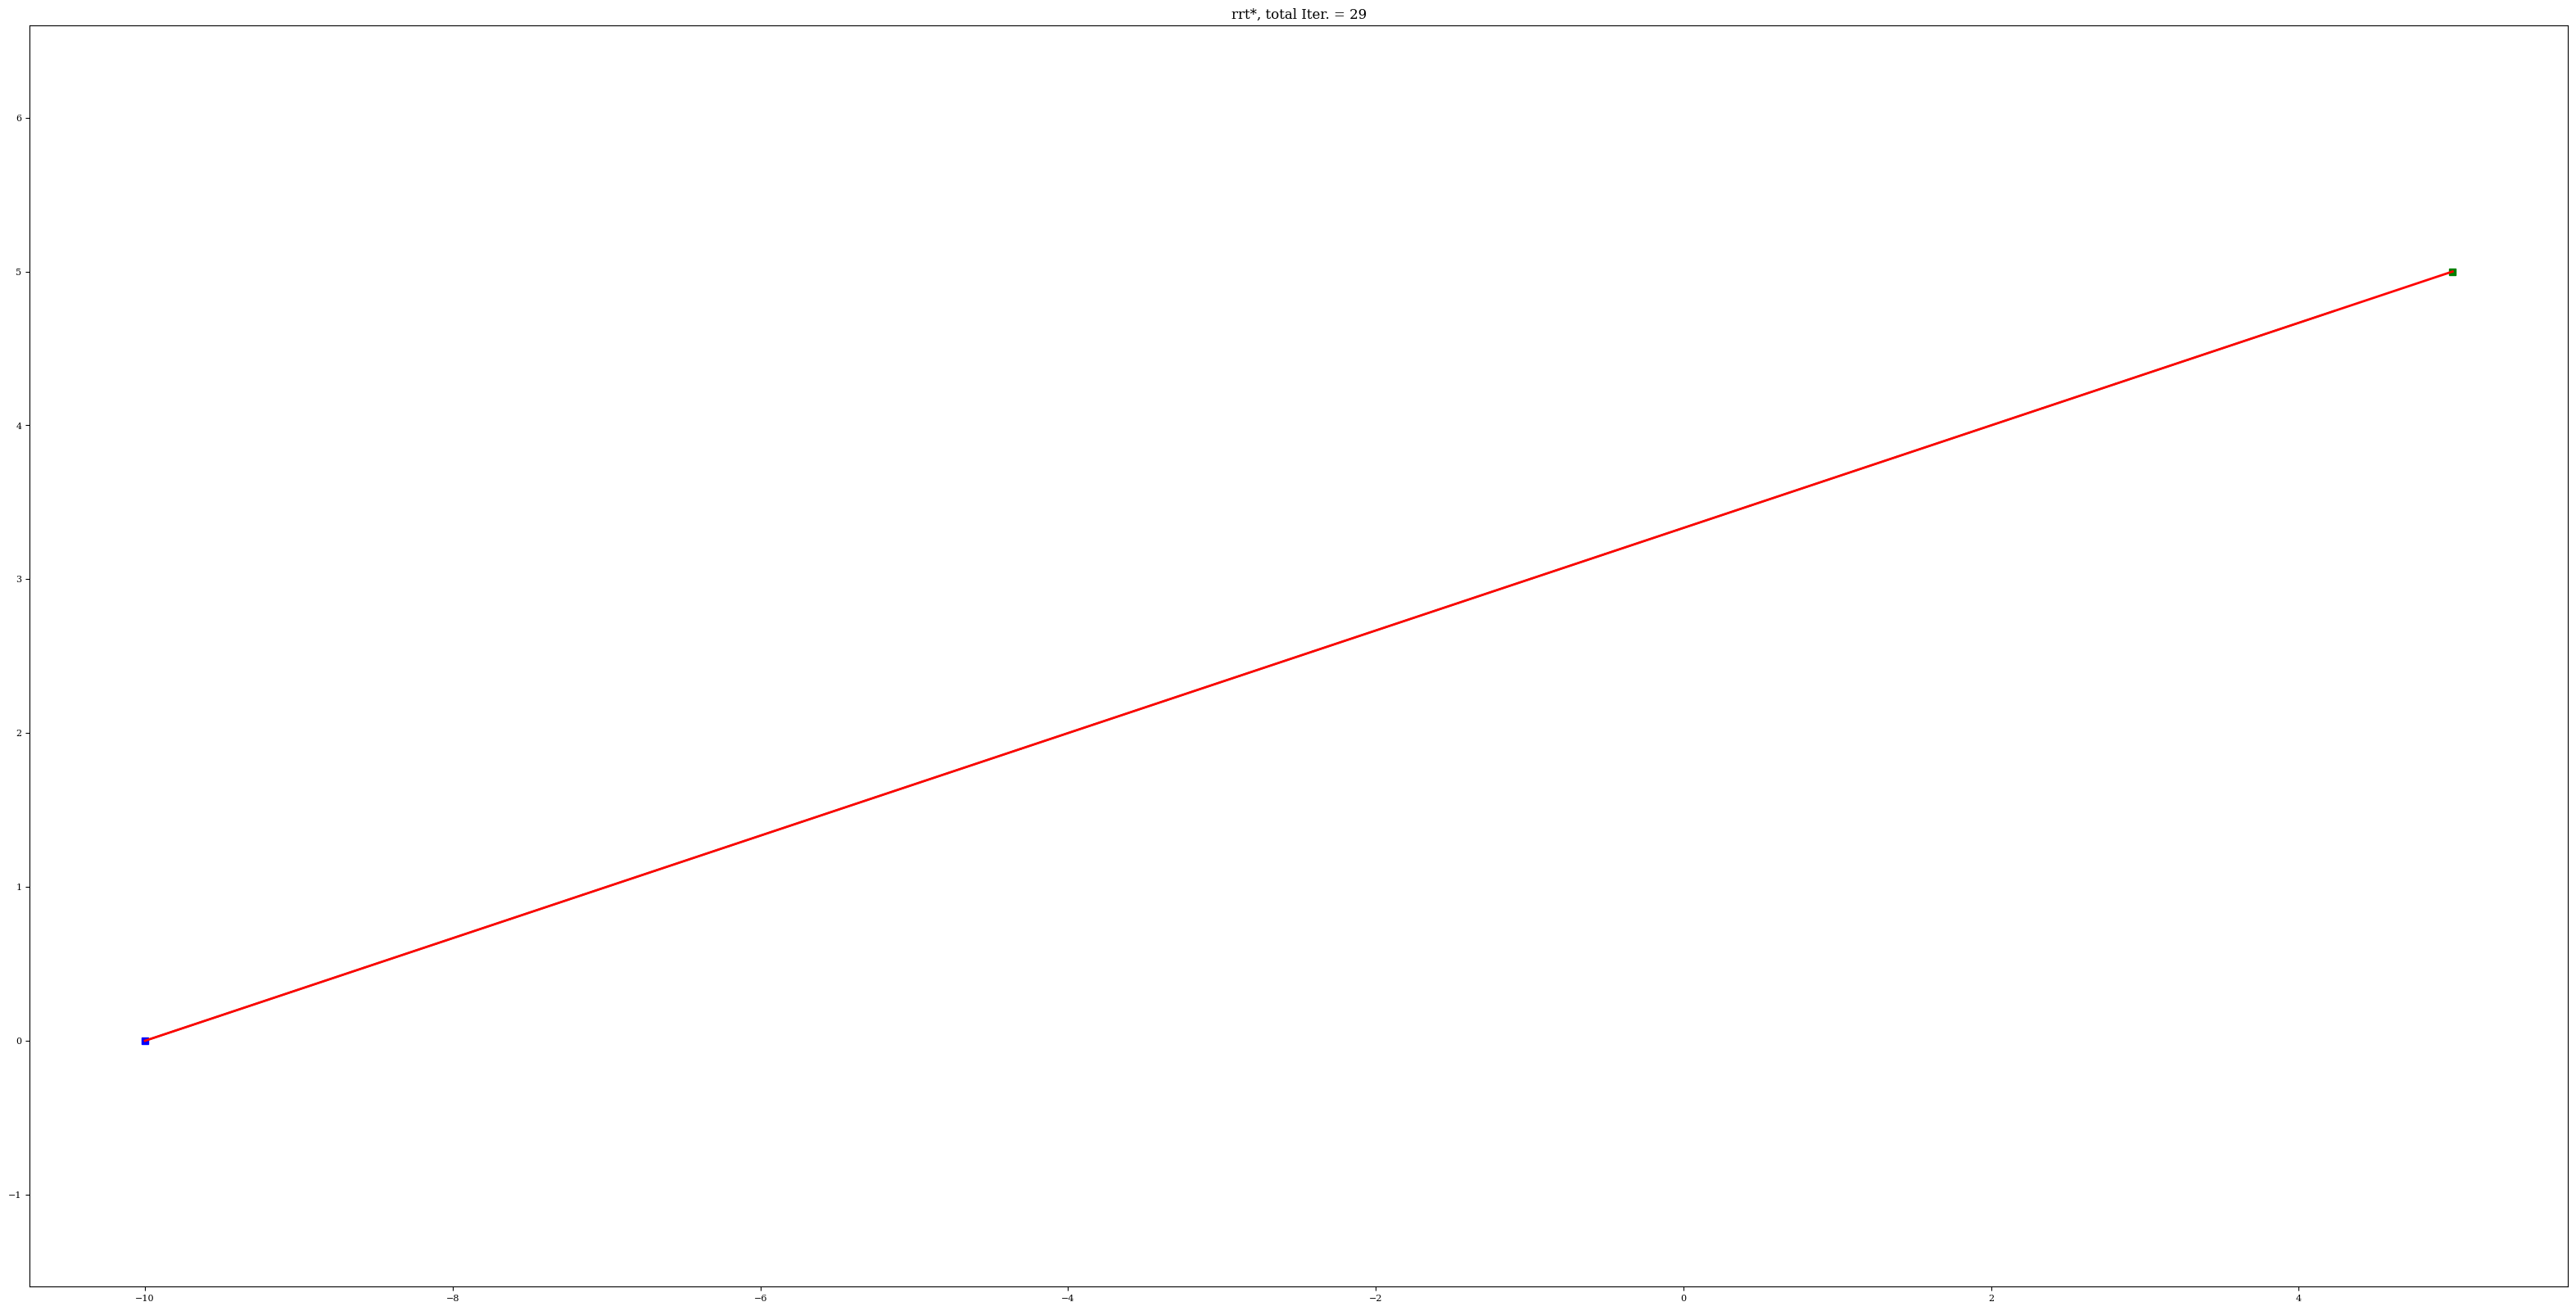

[[-10, 0],
 [-9.525658350974743, 0.15811388300841897],
 [-9.051316701949485, 0.316227766016838],
 [-8.576975052924228, 0.474341649025257],
 [-8.10263340389897, 0.632455532033676],
 [-7.628291754873714, 0.790569415042095],
 [-7.153950105848457, 0.948683298050514],
 [-6.679608456823201, 1.106797181058933],
 [-6.205266807797944, 1.264911064067352],
 [-5.7309251587726875, 1.423024947075771],
 [-5.256583509747431, 1.58113883008419],
 [-4.782241860722174, 1.739252713092609],
 [-4.307900211696918, 1.897366596101028],
 [-3.833558562671661, 2.055480479109447],
 [-3.359216913646404, 2.213594362117866],
 [-2.884875264621147, 2.371708245126285],
 [-2.41053361559589, 2.529822128134704],
 [-1.9361919665706329, 2.687936011143123],
 [-1.4618503175453759, 2.846049894151542],
 [-0.987508668520119, 3.004163777159961],
 [-0.5131670194948621, 3.16227766016838],
 [-0.03882537046960516, 3.320391543176799],
 [0.4355162785556518, 3.478505426185218],
 [0.9098579275809087, 3.636619309193637],
 [1.384199576606165

In [9]:
# Global Planner

global_start = (-10,0)
global_goal = (5,5)

global_planner = pypolo.planners.GlobalRRTStar(
            cfg.task_extent, rng, global_start, global_goal, step_len=0.5, goal_sample_rate=1, search_radius=0.6, iter_max=10000
            )
global_planner.plan()
global_planner.plot_map()
global_planner.path

### Initialize Local Grid

(-11.0, 11.0)

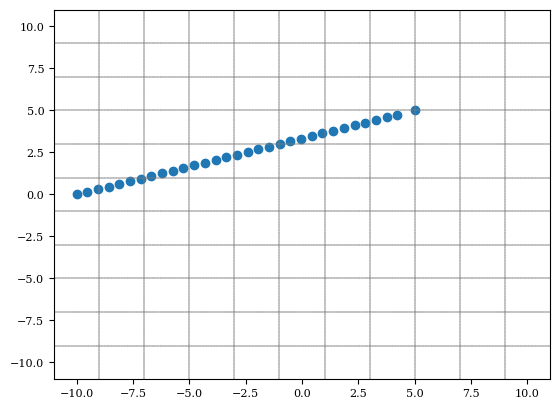

In [10]:
localGrid_info = {"center":[],
                "bound_x":[],
                "bound_y":[],
             "local_goal": [],
             "local_data":[],
             "all_centers":[],
             "k_grids":[],
             "(num_grid_x, num_grid_y)":[],
             "global_goal":[]
             }


# initialize clusters' centerpoints
# NOTE number of clusters = num_grid_x * num_grid_y

digit_step_len = 0.1
num_step_local = 20
num_grid_x = int((cfg.env_extent[1] - cfg.env_extent[0])/(num_step_local*digit_step_len))
num_grid_y = int((cfg.env_extent[3] - cfg.env_extent[2])/(num_step_local*digit_step_len))

k_grids = num_grid_x * num_grid_y #initilize number of clusters
all_center_point = []

xi = np.linspace(cfg.env_extent[0] , cfg.env_extent[1], num_grid_x + 1)
yi = np.flip(np.linspace(cfg.env_extent[2] , cfg.env_extent[3], num_grid_y + 1))

#Overlap-ness of the subgrids (defined in percentage)
overlap = 0

for i in  range(len(xi) - 1):
    for j in range(len(yi) - 1):
        
        # Set the bounds for each dimension
        bounds_x = (  xi[i] * (1-overlap)   ,  min(xi[i + 1] * (1+overlap), cfg.env_extent[1] ) )
        bounds_y = (  min(yi[j] * (1+overlap), cfg.env_extent[3]) , yi[j + 1] * (1-overlap) )
        
        # print("x", bounds_x)
        # print("y", bounds_y)     
        
        #Find center point of the grid
        midpoint_x = (bounds_x[0] + bounds_x[1]) / 2
        midpoint_y = (bounds_y[0] + bounds_y[1]) / 2

        plt.axvline(x=bounds_x[0], color='gray', linestyle='--', linewidth=0.1)
        plt.axhline(y=bounds_y[0], color='gray', linestyle='--', linewidth=0.1)
                
        # print(midpoint_x)
        # print(midpoint_y)
        localGrid_info["bound_x"].append(bounds_x)
        localGrid_info["bound_y"].append(bounds_y)
        localGrid_info["center"].append(np.atleast_2d([midpoint_x, midpoint_y]))
        all_center_point.append([midpoint_x, midpoint_y])
        
localGrid_info["all_centers"] = all_center_point
localGrid_info["k_grids"] = k_grids
localGrid_info["(num_grid_x, num_grid_y)"] = (num_grid_x, num_grid_y)
localGrid_info["global_goal"] = global_goal



plt.scatter(np.array(global_planner.path)[:,0], np.array(global_planner.path)[:,1])
plt.xlim(cfg.env_extent[0], cfg.env_extent[1])
plt.ylim(cfg.env_extent[2], cfg.env_extent[3])


In [11]:
def locate_state(localGrid_info ,state):
    
    #Get param
    k_grids = localGrid_info["k_grids"]
    
    state = np.atleast_2d(state)
    for index in range(k_grids):
        lb_x = localGrid_info["bound_x"][index][0]
        ub_x = localGrid_info["bound_x"][index][1]
        ub_y = localGrid_info["bound_y"][index][0]
        lb_y = localGrid_info["bound_y"][index][1]
        
        if (state[:,0] >= lb_x and state[:,0] <= ub_x) and (state[:,1] >= lb_y and state[:,1] <= ub_y):
            return index
    
def assign_subgoals(localGrid_info, global_path, plot_sub_goal=False):
    
    #Get param
    global_goal = localGrid_info["global_goal"]
    k_grids = localGrid_info["k_grids"]
    
    #Clear old data
    localGrid_info["local_data"] = []
    localGrid_info["local_goal"] = []
    
    for _ in range(k_grids):
        localGrid_info["local_data"].append(np.array([]))
        localGrid_info["local_goal"].append(np.array([]))
        
    
    #Assgin global waypoint to the different subgrid
    for subgoal in global_path:

        index = locate_state(localGrid_info, subgoal)
                
        if localGrid_info["local_goal"][index].shape[0] == 0:
            localGrid_info["local_goal"][index] = np.atleast_2d(np.append(localGrid_info["local_goal"][index] , subgoal))
        else:
            localGrid_info["local_goal"][index] = np.atleast_2d(np.vstack([localGrid_info["local_goal"][index] , subgoal]))
                    
    #Only keep the subgoal closest to the global goal
    for i in range(k_grids):
        if localGrid_info["local_goal"][i].shape[0] < 2:
            continue
        print(i)
        distances = np.linalg.norm(localGrid_info["local_goal"][i] - global_goal, axis=1)
        min_distance_index = np.argmin(distances)
        localGrid_info["local_goal"][i] = localGrid_info["local_goal"][i][min_distance_index]
        
    if plot_sub_goal:
        for i in range(k_grids):
            # print(localGrid_info["local_goal"][i].shape)
            if localGrid_info["local_goal"][i].shape[0] > 0:
                
                goal = np.atleast_2d(localGrid_info["local_goal"][i])
                plt.scatter(goal[:,0], goal[:,1])
                
            bound_x = localGrid_info["bound_x"][i]
            bound_y = localGrid_info["bound_y"][i]
            
            # print(localGrid_info["local_goal"][i])
            # print(localGrid_info["bound_x"][i])
            # print(localGrid_info["bound_y"][i])
            
            
            plt.axvline(x=bound_x[0], color='gray', linestyle='--', linewidth=0.1)
            plt.axvline(x=bound_x[1], color='gray', linestyle='--', linewidth=0.1)
            plt.axhline(y=bound_y[1], color='gray', linestyle='--', linewidth=0.1)
            plt.axhline(y=bound_y[0], color='gray', linestyle='--', linewidth=0.1)
            plt.xlim(cfg.env_extent[0] - 1, cfg.env_extent[1] + 1)
            plt.ylim(cfg.env_extent[2] - 1, cfg.env_extent[3] + 1)
            
def find_next_goal(localGrid_info, current_state):
    
    num_grid_x, num_grid_y = localGrid_info["(num_grid_x, num_grid_y)"]
    
    #Convert to matrix indices
    current_index = locate_state(localGrid_info, current_state)
    i, j = (current_index % (num_grid_y)), int(current_index / (num_grid_x)) 
    
    #Clear current goal
    localGrid_info["local_goal"][current_index] = []
    
    adjacent_indices = []
    if i > 0:
        adjacent_indices.append((i-1,j))
        if j > 0:
            adjacent_indices.append((i-1,j-1))
            
    if i+1 < (num_grid_y - 1):
        adjacent_indices.append((i+1,j))
        if j+1 < (num_grid_x - 1):
            adjacent_indices.append((i+1,j+1))
        
    if j > 0:
        adjacent_indices.append((i,j-1))
        if i+1 < (num_grid_y - 1):
            adjacent_indices.append((i+1,j-1))
        
    if j+1 < (num_grid_x - 1):
        adjacent_indices.append((i,j+1))
        if i > 0:
            adjacent_indices.append((i-1,j+1))
        
    for i_next, j_next in adjacent_indices:
        #Convert back to vectorized list
        next_index = j_next * num_grid_x + i_next
        
        if len(localGrid_info["local_goal"][next_index]) > 0:
            
            goal = np.atleast_1d(localGrid_info["local_goal"][next_index]) 
            return goal

            
    
    
    

5
16
26
37
48
58
69
80


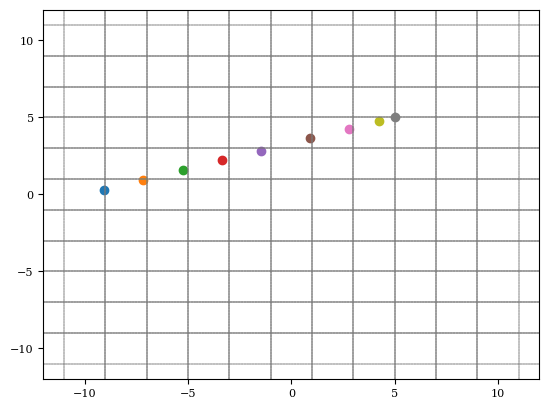

In [12]:
assign_subgoals(localGrid_info, global_planner.path, plot_sub_goal=True)

In [13]:
current_index = locate_state(localGrid_info, (-10,-10))
row, col = (current_index % (num_grid_y)), int(current_index / (num_grid_x)) 
print(row)
print(col)

10
0


### Evaluator

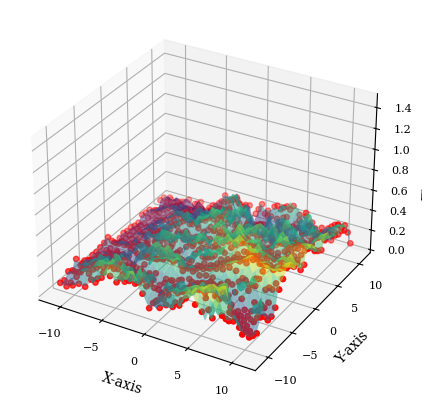

[[0.1092233 ]
 [0.09466019]
 [0.12378641]
 [0.16019417]
 [0.15048544]
 [0.24029126]
 [0.26699029]
 [0.35194175]
 [0.33495146]
 [0.29368932]
 [0.39320388]
 [0.34708738]
 [0.41747573]
 [0.26213592]
 [0.1407767 ]
 [0.22572816]
 [0.32038835]
 [0.33009709]
 [0.27669903]
 [0.31553398]
 [0.45145631]
 [0.31796117]
 [0.26941748]
 [0.30825243]
 [0.46116505]
 [0.29368932]
 [0.26213592]
 [0.32038835]
 [0.17475728]
 [0.16747573]
 [0.09951456]
 [0.09708738]
 [0.17475728]
 [0.26456311]
 [0.24514563]
 [0.17718447]
 [0.24514563]
 [0.37378641]
 [0.37135922]
 [0.29854369]
 [0.31067961]
 [0.41504854]
 [0.34466019]
 [0.30097087]
 [0.15533981]
 [0.12864078]
 [0.17718447]
 [0.17961165]
 [0.21359223]
 [0.30339806]
 [0.40291262]
 [0.4368932 ]
 [0.36650485]
 [0.19174757]
 [0.39563107]
 [0.22572816]
 [0.29126214]
 [0.18446602]
 [0.16504854]
 [0.14563107]
 [0.15533981]
 [0.17475728]
 [0.1868932 ]
 [0.24029126]
 [0.25242718]
 [0.31553398]
 [0.36650485]
 [0.34951456]
 [0.33495146]
 [0.23058252]
 [0.33009709]
 [0.26

In [13]:
#Evaluator for calculate and keep track of SMSES, RMSES, MAES, MSLLS, NLPDS (refer to the Paper)
                                        #orig: env_extent
evaluator = pypolo.utils.Evaluator(sensor, cfg.env_extent, cfg.eval_grid)

# Create a 3D plot for evaluation points
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X,Y,env,cmap='viridis', alpha=0.5)
ax.scatter(evaluator.eval_inputs[:,0],evaluator.eval_inputs[:,1],evaluator.eval_outputs,color='red', s=15)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Elevation')
ax.set_zlim([0, 1.5])

plt.show()
print(evaluator.eval_outputs)

Collected 100 samples in pilot survey.
num_samples []
training_times []


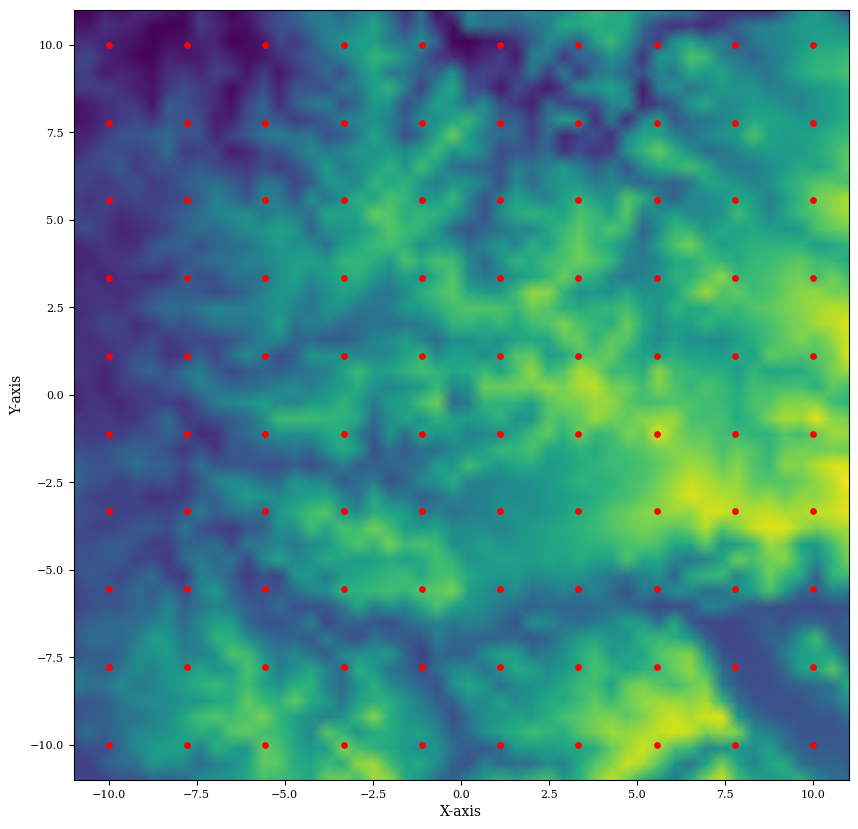

In [14]:
x_init, y_init =  pilot_survey(cfg, sensor, rng)

x_scaler = MinMaxScaler()
x_scaler.fit(x_init) #find min/max of (x1,x2) coordinates
y_scaler = StandardScaler()
y_scaler.fit(y_init) #find mean and std of y_init
evaluator.add_data(x_init, y_init) #set training data
print("num_samples", evaluator.num_samples)
print("training_times", evaluator.training_times)


# #Add untraversable terrain to planner map
# risk_index = np.where(y_init > max_z_digit)[0]    

# #Replan
# if not risk_index.shape[0] == 0:
#     print("New risk region found")
    
#     planner.add_obstacle(x_init[risk_index])
#     planner.plan(robot)
#     robot.track_planner(planner)

fig = plt.figure(figsize=(10, 10))

# Create a 3D plot
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X,Y,env,cmap='viridis', alpha=0.5)
# ax.scatter(x_init[:,0],x_init[:,1],y_init*y_scaler.actual_std[0] +y_scaler.actual_mean[0] ,color='red', s=15)
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_zlabel('Elevation')
# ax.set_zlim([0, 1.5])

#2D representation
ax = fig.add_subplot(111)
ax.pcolormesh(X,Y,env,cmap='viridis', shading='gouraud')
ax.scatter(x_init[:,0],x_init[:,1] ,color='red', s=15)
# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

plt.show()
            

### Define Robot

In [15]:
start = np.array(global_start)
robot =  get_robot(cfg, sensor, start, heading_start=0)

#Define GP Model
model = get_model(cfg, x_init, y_init, x_scaler, y_scaler)
model_update(cfg.num_train_steps, model, evaluator)
print("losses", evaluator.losses)
print("training time", evaluator.training_times)


Initialized robot with control rate 10.0.
Model parameters:
Fast lr: 0.01 likelihood.noise_covar.raw_noise torch.Size([1])
Fast lr: 0.01 covar_module.raw_outputscale torch.Size([])
Slow lr: 0.001 covar_module.base_kernel.nn.0.weight torch.Size([10, 2])
Slow lr: 0.001 covar_module.base_kernel.nn.0.bias torch.Size([10])
Slow lr: 0.001 covar_module.base_kernel.nn.2.weight torch.Size([10, 10])
Slow lr: 0.001 covar_module.base_kernel.nn.2.bias torch.Size([10])
Slow lr: 0.001 covar_module.base_kernel.nn.4.weight torch.Size([10, 10])
Slow lr: 0.001 covar_module.base_kernel.nn.4.bias torch.Size([10])
Initialized model GPR with kernel AK.


/home/kmuenpra/anaconda3/envs/ak/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


losses [1.337920130512261, 1.335513691826368, 1.333116765084214, 1.3307298135275158, 1.3283532930060715, 1.3259876400338828, 1.3236332695756479, 1.3212905722522919, 1.3189599112139303, 1.3166416195085173]
training time [1.8814740180969238]


In [16]:
'''
TODO: Find a way to use evaluator to get all basic predictions of the local terrain
'''

evaluation(model, evaluator)
print("num_samples", evaluator.num_samples)
print("training_times", evaluator.training_times)

print("smses", evaluator.smses)
print("rmses", evaluator.rmses)
print("maes", evaluator.maes)
print("mslls", evaluator.mslls)
print("nlpds", evaluator.nlpds)

num_samples [100]
training_times [1.8814740180969238]
smses [0.3714464260408975]
rmses [0.06479551540018923]
maes [0.05191348868387112]
mslls [-0.266765544083681]
nlpds [-1.0886650204421955]


In [17]:
#Measure Before Plan

x_at_start, y_at_start = robot.sensor.sense( robot.state, robot.heading_c, ray_tracing = True, num_targets = 30)

model.add_data(x_at_start, y_at_start)
print("training x size", model.train_x.shape)
print("training y size",model.train_y.shape)

evaluator.add_data(x_at_start, y_at_start) #set training data
model_update(cfg.num_train_steps, model, evaluator)
print("losses", evaluator.losses)
print("training time", evaluator.training_times)

evaluation(model, evaluator)
print("num_samples", evaluator.num_samples)
print("training_times", evaluator.training_times)

training x size torch.Size([130, 2])
training y size torch.Size([130])
losses [1.337920130512261, 1.335513691826368, 1.333116765084214, 1.3307298135275158, 1.3283532930060715, 1.3259876400338828, 1.3236332695756479, 1.3212905722522919, 1.3189599112139303, 1.3166416195085173, 1.2900544228333055, 1.2878978533951957, 1.2857590250126758, 1.2836370264388395, 1.281531172329859, 1.2794409465247008, 1.2773659622706208, 1.275305933623545, 1.2732606544211762, 1.2712299824221165]
training time [1.8814740180969238, 0.0714111328125]
num_samples [100, 130]
training_times [1.8814740180969238, 0.0714111328125]


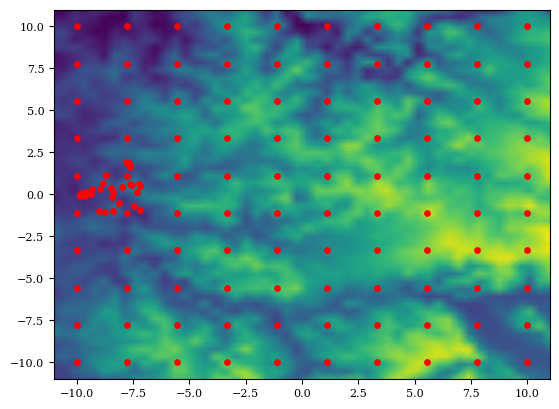

In [18]:
#2D representation
plt.pcolormesh(X,Y,env,cmap='viridis', shading='gouraud')
# plt.scatter(x_init[:,0],x_init[:,1] ,color='red', s=15)
# plt.scatter(x_at_start[:,0],x_at_start[:,1] ,color='red', s=15)

plt.scatter(model.x_train[:,0],model.x_train[:,1] ,color='red', s=15)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

plt.show()

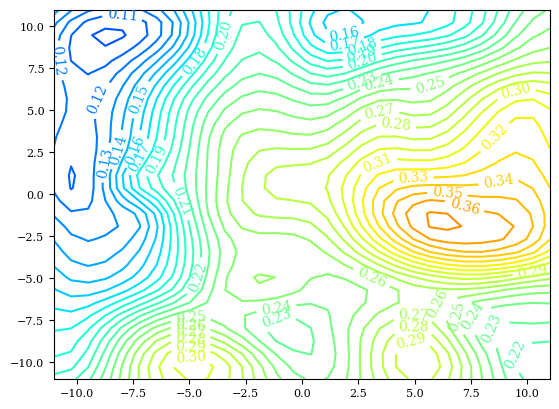

In [19]:
#Replan Global Trajectory
mean, std = model.predict(evaluator.eval_inputs)
obstacles = []

levels = np.arange(0, max_height, 0.01)
contours = plt.contour(evaluator.eval_inputs[:,0].reshape(-1,30), evaluator.eval_inputs[:,1].reshape(-1,30), mean.reshape(-1,30), levels)
plt.clabel(contours, inline=1, fontsize=10)
# for level, path in zip(contours.levels, contours.get_paths()):
#     print(level)
#     print(path)

x = np.linspace(cfg.env_extent[0], cfg.env_extent[1], cfg.eval_grid[0])
y = np.linspace(cfg.env_extent[2], cfg.env_extent[3], cfg.eval_grid[1])

grad_x, grad_y = np.gradient(mean.reshape(-1,30), x,y)
# plt.quiver(evaluator.eval_inputs[:,0].reshape(-1,30), evaluator.eval_inputs[:,1].reshape(-1,30), grad_x, grad_y, scale=1000, color='red', label='Gradient')


# levels = np.arange(np.min(std), np.max(std), 0.001)
# contours = plt.contour(evaluator.eval_inputs[:,0].reshape(-1,30), evaluator.eval_inputs[:,1].reshape(-1,30), std.reshape(-1,30), levels)
# plt.clabel(contours, inline=1, fontsize=10)


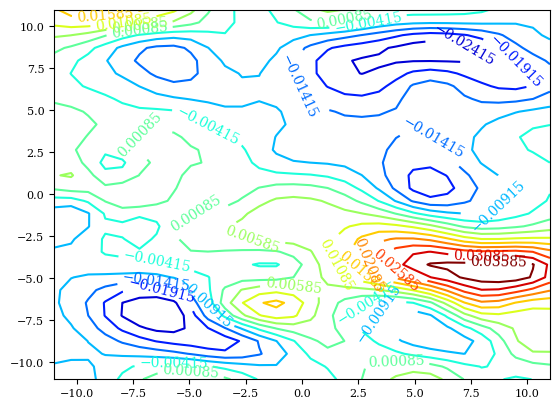

In [20]:
#Gradient along x
levels = np.arange(np.min(grad_x), np.max(grad_x), 0.005)
contours = plt.contour(evaluator.eval_inputs[:,0].reshape(-1,30), evaluator.eval_inputs[:,1].reshape(-1,30), grad_x, levels)
plt.clabel(contours, inline=1, fontsize=10)

for level, path in zip(contours.levels, contours.get_paths()):
    if abs(level) > 0.03:
        obstacles.append(path)

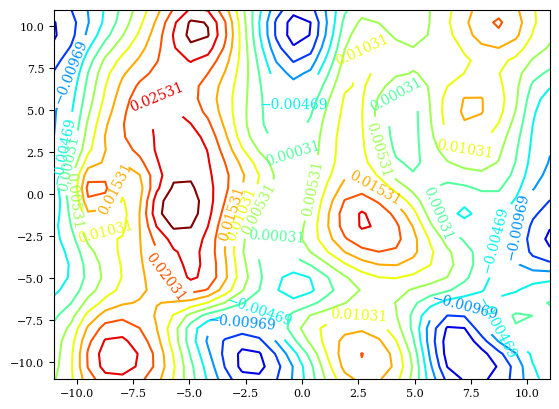

In [21]:
# #Gradient along y
levels = np.arange(np.min(grad_y), np.max(grad_y), 0.005)
contours = plt.contour(evaluator.eval_inputs[:,0].reshape(-1,30), evaluator.eval_inputs[:,1].reshape(-1,30), grad_y, levels)
plt.clabel(contours, inline=1, fontsize=10)

for level, path in zip(contours.levels, contours.get_paths()):
    if abs(level) >  0.03:
        obstacles.append(path)

In [23]:
# import geopandas as gpd
# from shapely.geometry import Polygon
# from shapely.ops import unary_union

# all_polygon = []
# i = 0
# for i in range(len(obstacles)):
#     polys = [Polygon(obstacles[i].vertices)]
#     merges_index = [i]
#     for j in range(len(obstacles)):
#         if j != i:
#             if np.linalg.norm(np.mean(obstacles[i].vertices) - np.mean(obstacles[j].vertices)) < 0.9:
#                polys.append(Polygon(obstacles[j].vertices))
#             #    merges_index.append(j)
            
#     mergedPolys = unary_union(polys)
#     gpd.GeoSeries([mergedPolys]).boundary.plot()
#     break
        
                
        
    
    # all_polygon.append(Polygon(path.vertices))
    
# gpd.GeoSeries(all_polygon).boundary.plot()
# plt.show()

current waypoint:  (-5.233315251994403, 1.98726462789827)
0


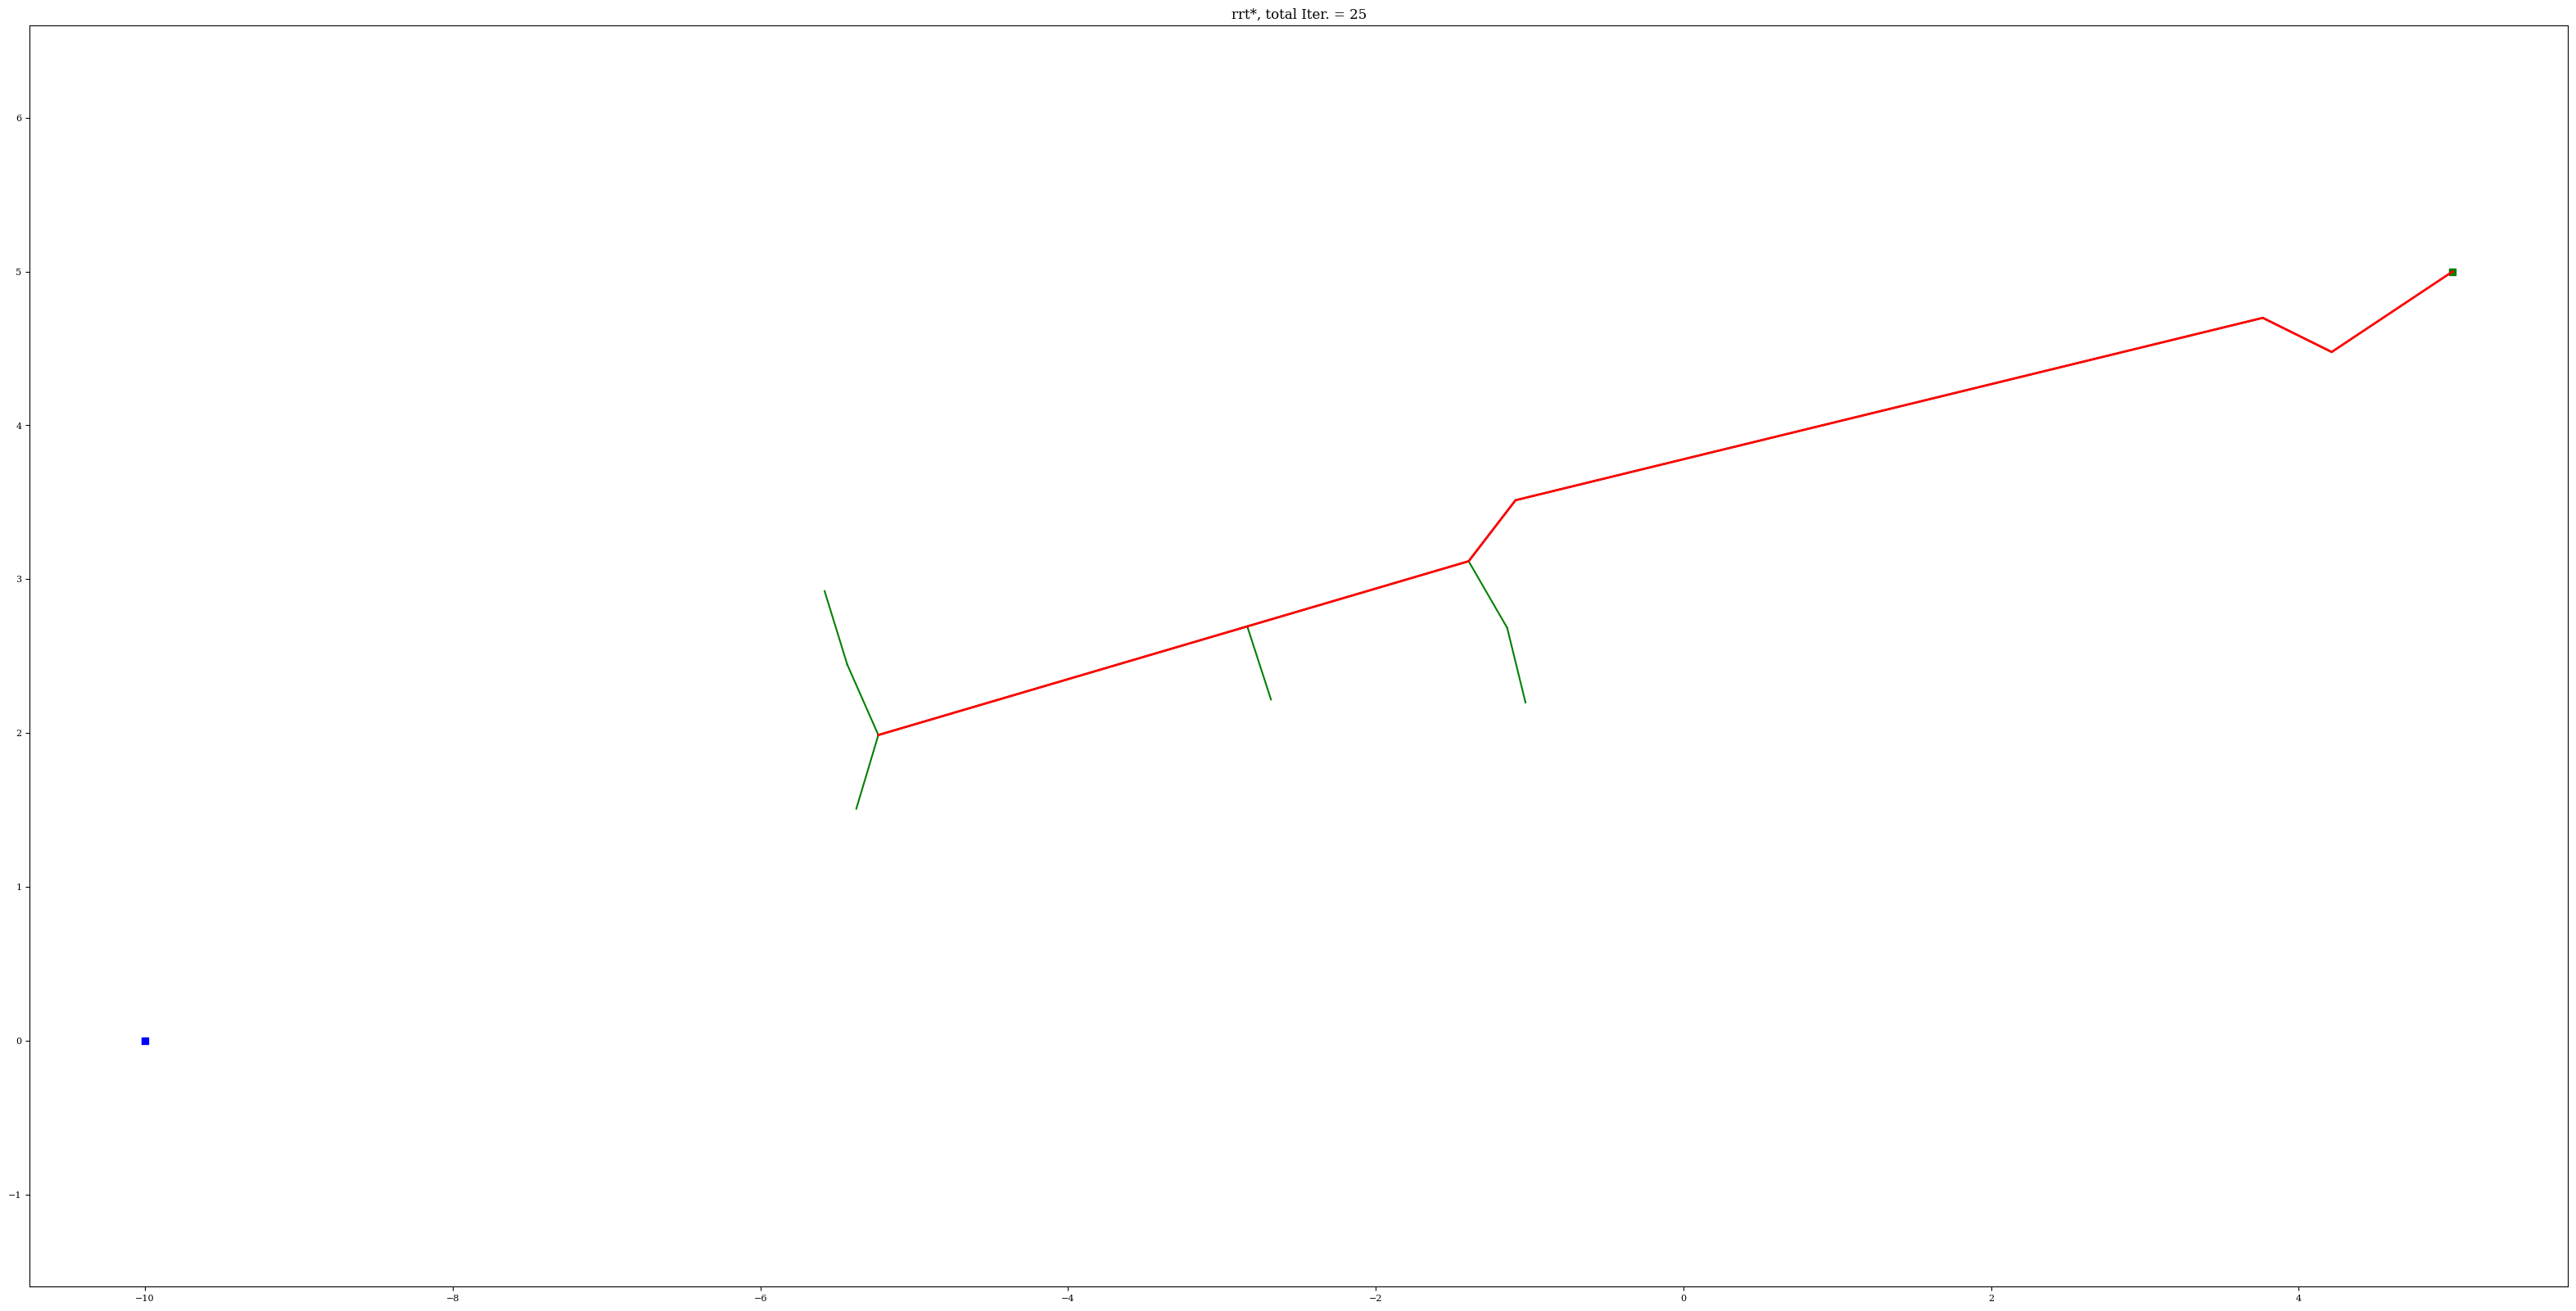

In [40]:
global_planner.goal_sample_rate = 0.6
global_planner.utils.delta = 1

# global_planner.update_obs(obs_cir=[], obs_bound=[], obs_rec=[], obstacles=obstacles)

# global_planner.plotting.plot_grid("Env")

class Node:
    def __init__(self, n):
        self.x = n[0]
        self.y = n[1]
        self.parent = None

global_planner.s_start = Node((robot.wp_c_x, robot.wp_c_y))
print("current waypoint: ", (robot.wp_c_x, robot.wp_c_y))
# global_planner.reset_tree(start=(robot.wp_c_x, robot.wp_c_y))

global_planner.path = []
global_planner.vertex = [global_planner.s_start]
global_planner.path_vertex = []

global_planner.plan()
global_planner.plot_map()

37
47
48
58
69
80


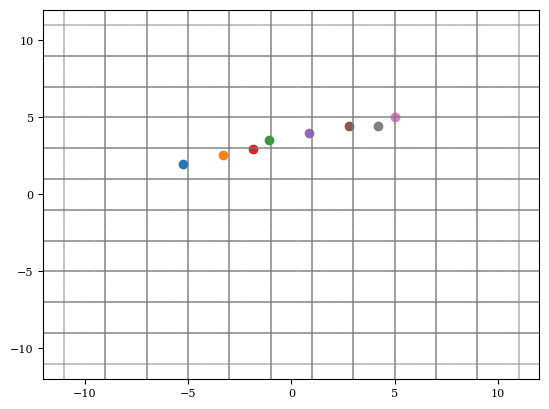

In [41]:
assign_subgoals(localGrid_info=localGrid_info, global_path=global_planner.path, plot_sub_goal=True)

### Local Planner

In [21]:
#Local Planner that robot tracks

start = np.array(global_start)
loc_ind = locate_state(localGrid_info, robot.state[:2]) #Find which subgrid robot locates in
goal = np.atleast_1d(localGrid_info["local_goal"][loc_ind]) 
print(goal)

planner =  get_planner(cfg, rng, start, goal=goal)



# #Generate a trajectory toward goal
planner.plan(heading_c = robot.state[2])

robot.update_new_path(model, planner.path)

#Update State
# vapex = 0.15
# robot.hard_update_state(vapex=vapex)


[-9.0513167   0.31622777]
Initialized planner LocalRRTStar.
0


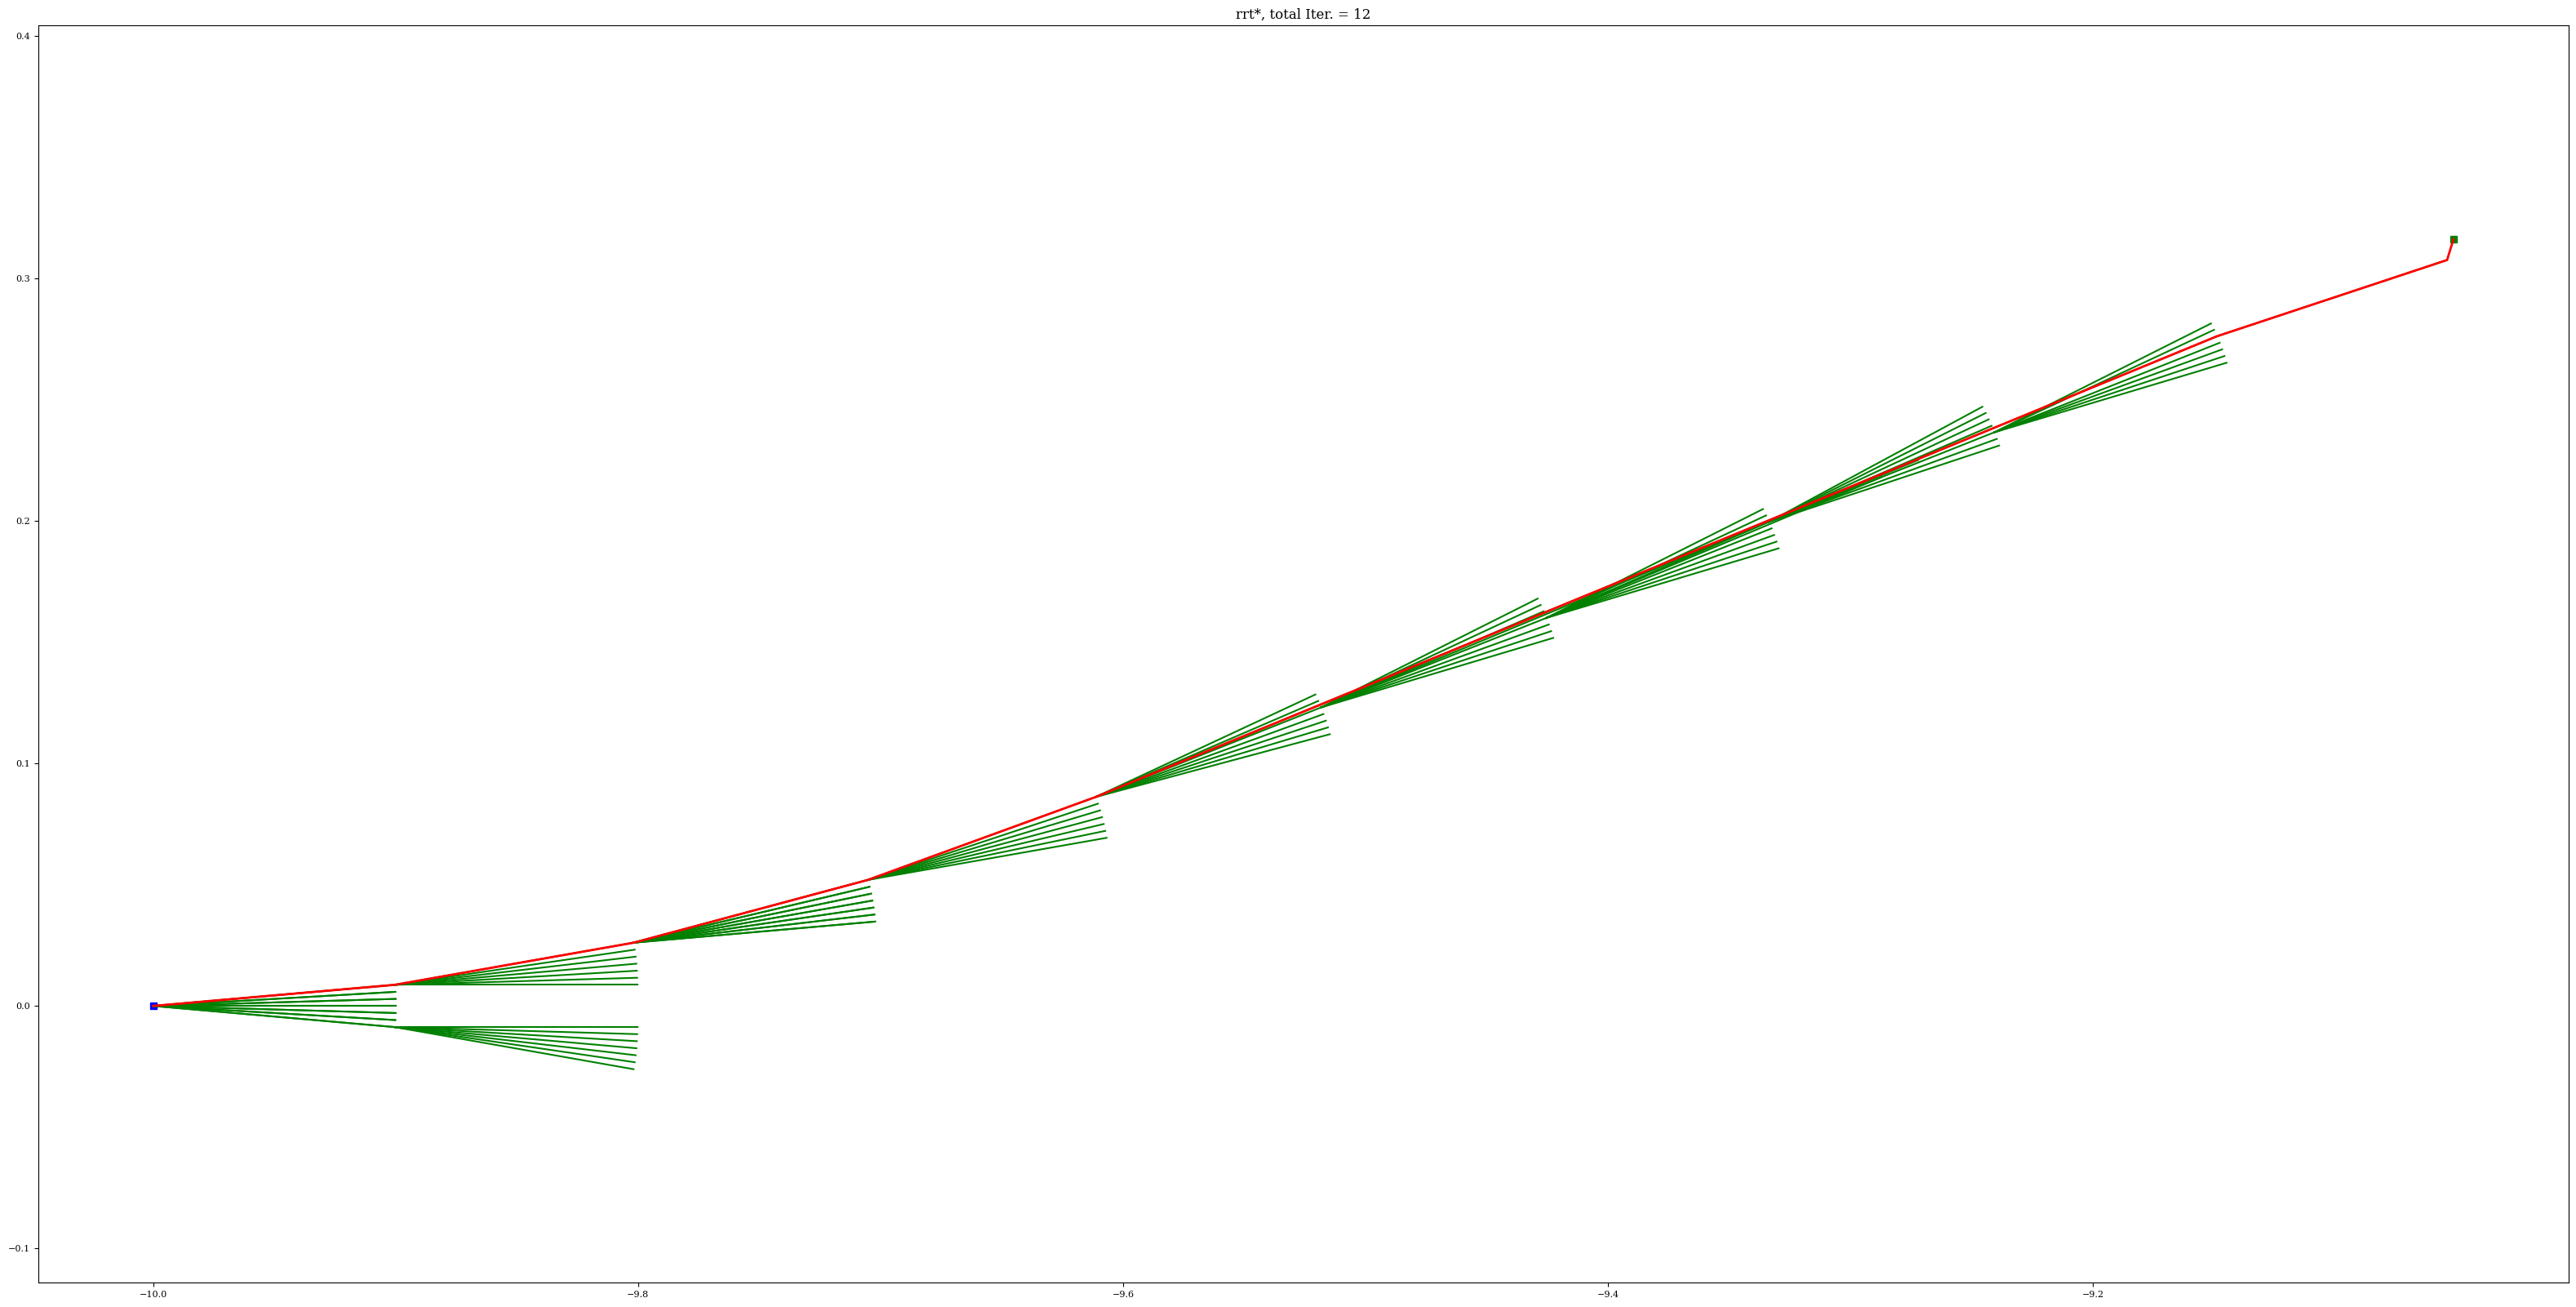

In [22]:
planner.plot_map()

In [42]:
#Plan toward next goal

goal = find_next_goal(localGrid_info=localGrid_info, current_state=(robot.wp_c_x, robot.wp_c_y))
print("goal", goal)
planner.reset_tree(start=(robot.wp_c_x, robot.wp_c_y), goal=tuple(goal))
planner.plan(heading_c = robot.state[2])

robot.update_new_path(model, planner.path)



goal [-3.31473336  2.55210402]
0


In [59]:
a = [[2,1]]
tuple(np.array(a).flatten())

(2, 1)

<a list of 13 text.Text objects>

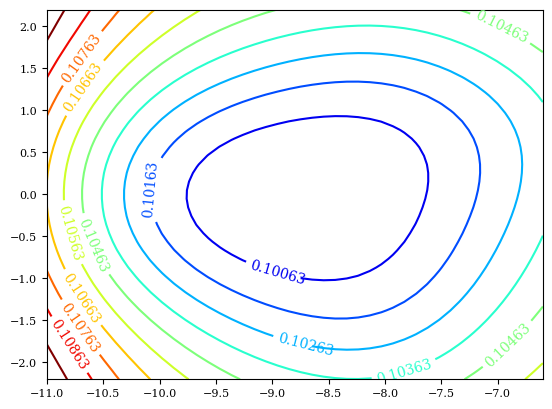

In [80]:
x_min, x_max = localGrid_info["bound_x"][loc_ind]
y_min, y_max = localGrid_info["bound_y"][loc_ind]
x_steps = int((x_max - x_min)/planner.step_len)
y_steps = int((y_max - y_min)/planner.step_len)

x_grid = np.linspace(x_min, x_max, x_steps)
y_grid = np.linspace(y_min, y_max, y_steps)
xx, yy = np.meshgrid(x_grid, y_grid)
local_test_inputs = np.column_stack((xx.flatten(), yy.flatten()))


#Replan Global Trajectory
mean, std = model.predict(local_test_inputs)
obstacles = []

# levels = np.arange(np.min(mean), np.max(mean), 0.005)
# contours = plt.contour(local_test_inputs[:,0].reshape(-1,20), local_test_inputs[:,1].reshape(-1,20), mean.reshape(-1,20), levels)
# plt.clabel(contours, inline=1, fontsize=10)
# for level, path in zip(contours.levels, contours.get_paths()):
#     print(level)
#     print(path)




x = np.linspace(x_min, x_max, x_steps)
y = np.linspace(y_min, y_max, y_steps)

grad_x, grad_y = np.gradient(mean.reshape(x_steps, y_steps), x,y)
# plt.quiver(evaluator.eval_inputs[:,0].reshape(-1,30), evaluator.eval_inputs[:,1].reshape(-1,30), grad_x, grad_y, scale=1000, color='red', label='Gradient')


levels = np.arange(np.min(std), np.max(std), 0.001)
contours = plt.contour(local_test_inputs[:,0].reshape(x_steps, y_steps), local_test_inputs[:,1].reshape(x_steps, y_steps), std.reshape(x_steps, y_steps), levels)
plt.clabel(contours, inline=1, fontsize=10)

<a list of 8 text.Text objects>

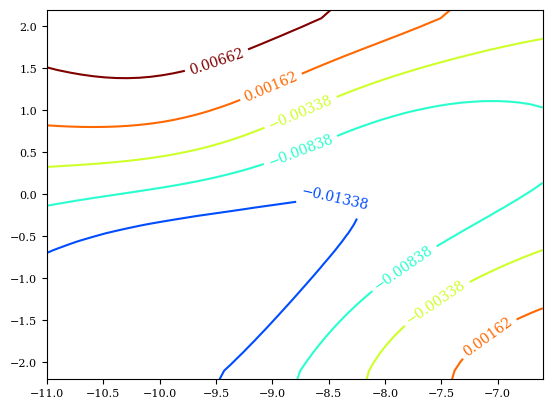

In [81]:
#Gradient along x
levels = np.arange(np.min(grad_x), np.max(grad_x), 0.005)
contours = plt.contour(local_test_inputs[:,0].reshape(x_steps, y_steps), local_test_inputs[:,1].reshape(x_steps, y_steps), grad_x, levels)
plt.clabel(contours, inline=1, fontsize=10)

# for level, path in zip(contours.levels, contours.get_paths()):
#     if abs(level) > 0.07/0.3:
#         obstacles.append(path)

<a list of 11 text.Text objects>

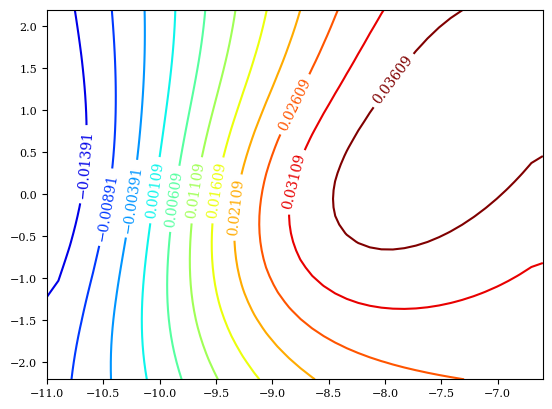

In [82]:
# #Gradient along y
levels = np.arange(np.min(grad_y), np.max(grad_y), 0.005)
contours = plt.contour(local_test_inputs[:,0].reshape(x_steps, y_steps), local_test_inputs[:,1].reshape(x_steps, y_steps), grad_y, levels)
plt.clabel(contours, inline=1, fontsize=10)

# for level, path in zip(contours.levels, contours.get_paths()):
#     if abs(level) >  0.07/0.3:
#         obstacles.append(path)

In [43]:
x_new, y_new = information_gathering(model, robot, planner, num_step=100, samples_per_dt=10, visualizer=visualizer)

Run information_gathering
goal: [[-5.1403805   2.02418524]]


<Figure size 640x480 with 0 Axes>

state:  [-5.23303336  1.98670333  0.46542113]
current apex state:  (-5.142057254677915, 2.0284058879736584)
---------- Digit's PSP ---------
PSP waypoint (-5.140380499571721, 2.0241852426295392, 1.2091645108591909)
current waypoint (-5.140380499571721, 2.0241852426295392)
next waypoint (-5.044581548340172, 2.052865565900649)
vapex 0.2
step_l 0.10000000000000028
dz 0.003368288069106773
next dtheta -5.000000000000013
PSP current dtheta -4.999999999999959
PSP current head 21.66666666666717
PSP t1 0.231
PSP t2 0.23
stance 1
-----------------------------------
goal: [[-5.04458155  2.05286557]]


<Figure size 640x480 with 0 Axes>

state:  [-5.14205725  2.02840589  0.37815467]
current apex state:  (-5.047254874917117, 2.061795098526548)
---------- Digit's PSP ---------
PSP waypoint (-5.044581548340172, 2.052865565900649, 1.2125327989282977)
current waypoint (-5.044581548340172, 2.052865565900649)
next waypoint (-4.942131456560735, 2.0825251044695476)
vapex 0.2
step_l 0.10665697133209413
dz 0.003577597531107618
next dtheta -0.5208143953937142
PSP current dtheta -5.000000000000013
PSP current head 16.666666666667155
PSP t1 0.231
PSP t2 0.231
stance 0
-----------------------------------
goal: [[-4.94213146  2.0825251 ]]


<Figure size 640x480 with 0 Axes>

state:  [-5.04725487  2.0617951   0.29088821]
current apex state:  (-4.944047957031826, 2.0891450877407816)
---------- Digit's PSP ---------
PSP waypoint (-4.942131456560735, 2.0825251044695476, 1.2161103964594053)
current waypoint (-4.942131456560735, 2.0825251044695476)
next waypoint (-4.839681364781296, 2.1121846430384457)
vapex 0.2
step_l 0.10665697133209487
dz 0.0035422220341390087
next dtheta -3.625832336868409e-13
PSP current dtheta -0.5208143953937142
PSP current head 16.14585227127344
PSP t1 0.243
PSP t2 0.244
stance 1
-----------------------------------
goal: [[-4.83968136  2.11218464]]


<Figure size 640x480 with 0 Axes>

state:  [-4.94404796  2.08914509  0.28179828]
current apex state:  (-4.842393177561407, 2.1215517971351145)
---------- Digit's PSP ---------
PSP waypoint (-4.839681364781296, 2.1121846430384457, 1.2196526184935443)
current waypoint (-4.839681364781296, 2.1121846430384457)
next waypoint (-4.737231273001859, 2.141844181607344)
vapex 0.2
step_l 0.10665697133209413
dz 0.0034963787283992798
next dtheta 3.625832336868409e-13
PSP current dtheta -3.625832336868409e-13
PSP current head 16.14585227127308
PSP t1 0.243
PSP t2 0.244
stance 0
-----------------------------------
goal: [[-4.73723127  2.14184418]]


<Figure size 640x480 with 0 Axes>

state:  [-4.84239318  2.1215518   0.28179828]
current apex state:  (-4.739152569789568, 2.1484807323338204)
---------- Digit's PSP ---------
PSP waypoint (-4.737231273001859, 2.141844181607344, 1.2231489972219436)
current waypoint (-4.737231273001859, 2.141844181607344)
next waypoint (-4.63478118122242, 2.171503720176242)
vapex 0.2
step_l 0.10665697133209487
dz 0.003441018754916675
next dtheta -3.625832336868409e-13
PSP current dtheta 3.625832336868409e-13
PSP current head 16.14585227127344
PSP t1 0.243
PSP t2 0.244
stance 1
-----------------------------------
goal: [[-4.63478118  2.17150372]]


<Figure size 640x480 with 0 Axes>

state:  [-4.73915257  2.14848073  0.28179828]
current apex state:  (-4.637545659668771, 2.1810527922190546)
---------- Digit's PSP ---------
PSP waypoint (-4.63478118122242, 2.171503720176242, 1.2265900159768603)
current waypoint (-4.63478118122242, 2.171503720176242)
next waypoint (-4.532331089442983, 2.2011632587451406)
vapex 0.2
step_l 0.10665697133209413
dz 0.0033768838550115587
next dtheta 3.625832336868409e-13
PSP current dtheta -3.625832336868409e-13
PSP current head 16.14585227127308
PSP t1 0.243
PSP t2 0.244
stance 0
-----------------------------------
goal: [[-4.53233109  2.20116326]]


<Figure size 640x480 with 0 Axes>

state:  [-4.63754566  2.18105279  0.28179828]
current apex state:  (-4.534257471234591, 2.2078173741115688)
---------- Digit's PSP ---------
PSP waypoint (-4.532331089442983, 2.2011632587451406, 1.2299668998318718)
current waypoint (-4.532331089442983, 2.2011632587451406)
next waypoint (-4.4298809976635445, 2.2308227973140387)
vapex 0.2
step_l 0.10665697133209487
dz 0.003304524066838732
next dtheta -3.625832336868409e-13
PSP current dtheta 3.625832336868409e-13
PSP current head 16.14585227127344
PSP t1 0.243
PSP t2 0.244
stance 1
-----------------------------------
goal: [[-4.429881   2.2308228]]


<Figure size 640x480 with 0 Axes>

state:  [-4.53425747  2.20781737  0.28179828]
current apex state:  (-4.4326910139838, 2.24052916645539)
---------- Digit's PSP ---------
PSP waypoint (-4.4298809976635445, 2.2308227973140387, 1.2332714238987106)
current waypoint (-4.4298809976635445, 2.2308227973140387)
next waypoint (-4.327430905884107, 2.260482335882937)
vapex 0.2
step_l 0.10665697133209413
dz 0.0032243292673071744
next dtheta 3.625832336868409e-13
PSP current dtheta -3.625832336868409e-13
PSP current head 16.14585227127308
PSP t1 0.243
PSP t2 0.244
stance 0
-----------------------------------
goal: [[-4.32743091  2.26048234]]


<Figure size 640x480 with 0 Axes>

state:  [-4.43269101  2.24052917  0.28179828]
current apex state:  (-4.329362616640096, 2.2671548585785497)
---------- Digit's PSP ---------
PSP waypoint (-4.327430905884107, 2.260482335882937, 1.2364957531660177)
current waypoint (-4.327430905884107, 2.260482335882937)
next waypoint (-4.2249808141046685, 2.290141874451835)
vapex 0.2
step_l 0.10665697133209487
dz 0.003136570157674101
next dtheta -3.625832336868409e-13
PSP current dtheta 3.625832336868409e-13
PSP current head 16.14585227127344
PSP t1 0.243
PSP t2 0.244
stance 1
-----------------------------------
goal: [[-4.22498081  2.29014187]]


<Figure size 640x480 with 0 Axes>

state:  [-4.32936262  2.26715486  0.28179828]
current apex state:  (-4.227830440932559, 2.2999850663604446)
---------- Digit's PSP ---------
PSP waypoint (-4.2249808141046685, 2.290141874451835, 1.2396323233236917)
current waypoint (-4.2249808141046685, 2.290141874451835)
next waypoint (-4.122530722325231, 2.3198014130207336)
vapex 0.2
step_l 0.10665697133209413
dz 0.0030414444788838257
next dtheta 3.625832336868409e-13
PSP current dtheta -3.625832336868409e-13
PSP current head 16.14585227127308
PSP t1 0.243
PSP t2 0.244
stance 0
-----------------------------------
goal: [[-4.12253072  2.31980141]]


<Figure size 640x480 with 0 Axes>

state:  [-4.22783044  2.29998507  0.28179828]
current apex state:  (-4.124467968788459, 2.326493057177507)
---------- Digit's PSP ---------
PSP waypoint (-4.122530722325231, 2.3198014130207336, 1.2426737678025754)
current waypoint (-4.122530722325231, 2.3198014130207336)
next waypoint (-4.020080630545793, 2.3494609515896316)
vapex 0.2
step_l 0.10665697133209487
dz 0.0029391245872424088
next dtheta -3.625832336868409e-13
PSP current dtheta 3.625832336868409e-13
PSP current head 16.14585227127344
PSP t1 0.243
PSP t2 0.244
stance 1
-----------------------------------
goal: [[-4.02008063  2.34946095]]


<Figure size 640x480 with 0 Axes>

state:  [-4.12446797  2.32649306  0.28179828]
current apex state:  (-4.022964939750007, 2.3594239434954436)
---------- Digit's PSP ---------
PSP waypoint (-4.020080630545793, 2.3494609515896316, 1.245612892389818)
current waypoint (-4.020080630545793, 2.3494609515896316)
next waypoint (-3.917630538766355, 2.37912049015853)
vapex 0.2
step_l 0.10665697133209413
dz 0.002829802960465061
next dtheta 3.625832336868409e-13
PSP current dtheta -3.625832336868409e-13
PSP current head 16.14585227127308
PSP t1 0.243
PSP t2 0.244
stance 0
-----------------------------------
goal: [[-3.91763054  2.37912049]]


<Figure size 640x480 with 0 Axes>

state:  [-4.02296494  2.35942394  0.28179828]
current apex state:  (-3.919573496712612, 2.385831862941866)
---------- Digit's PSP ---------
PSP waypoint (-3.917630538766355, 2.37912049015853, 1.248442695350283)
current waypoint (-3.917630538766355, 2.37912049015853)
next waypoint (-3.815180446986917, 2.408780028727428)
vapex 0.2
step_l 0.10665697133209444
dz 0.002713732703605809
next dtheta -2.9579158537610705e-13
PSP current dtheta 3.625832336868409e-13
PSP current head 16.14585227127344
PSP t1 0.243
PSP t2 0.244
stance 1
-----------------------------------
goal: [[-3.81518045  2.40878003]]


<Figure size 640x480 with 0 Axes>

state:  [-3.9195735   2.38583186  0.28179828]
current apex state:  (-3.8180953422028403, 2.418848670952089)
---------- Digit's PSP ---------
PSP waypoint (-3.815180446986917, 2.408780028727428, 1.2511564280538887)
current waypoint (-3.815180446986917, 2.408780028727428)
next waypoint (-3.712730355207479, 2.4384395672963266)
vapex 0.2
step_l 0.10665697133209456
dz 0.002591260671186202
next dtheta 2.2899993706537323e-13
PSP current dtheta -2.9579158537610705e-13
PSP current head 16.145852271273146
PSP t1 0.243
PSP t2 0.244
stance 0
-----------------------------------
goal: [[-3.71273036  2.43843957]]


<Figure size 640x480 with 0 Axes>

state:  [-3.81809534  2.41884867  0.28179828]
current apex state:  (-3.7146791746484245, 2.445171186877077)
---------- Digit's PSP ---------
PSP waypoint (-3.712730355207479, 2.4384395672963266, 1.2537476887250751)
current waypoint (-3.712730355207479, 2.4384395672963266)
next waypoint (-3.610280263428041, 2.4680991058652246)
vapex 0.2
step_l 0.10665697133209444
dz 0.002462851416448031
next dtheta -2.2899993706537323e-13
PSP current dtheta 2.2899993706537323e-13
PSP current head 16.145852271273373
PSP t1 0.243
PSP t2 0.244
stance 1
-----------------------------------
goal: [[-3.61028026  2.46809911]]


<Figure size 640x480 with 0 Axes>

state:  [-3.71467917  2.44517119  0.28179828]
current apex state:  (-3.613222340659857, 2.4782616403133435)
---------- Digit's PSP ---------
PSP waypoint (-3.610280263428041, 2.4680991058652246, 1.2562105401415231)
current waypoint (-3.610280263428041, 2.4680991058652246)
next waypoint (-3.507830171648603, 2.497758644434123)
vapex 0.2
step_l 0.10665697133209456
dz 0.002329100823371094
next dtheta 2.2899993706537323e-13
PSP current dtheta -2.2899993706537323e-13
PSP current head 16.145852271273146
PSP t1 0.243
PSP t2 0.244
stance 0
-----------------------------------
goal: [[-3.50783017  2.49775864]]


<Figure size 640x480 with 0 Axes>

state:  [-3.61322234  2.47826164  0.28179828]
current apex state:  (-3.509784981162623, 2.504510954948241)
---------- Digit's PSP ---------
PSP waypoint (-3.507830171648603, 2.497758644434123, 1.2585396409648941)
current waypoint (-3.507830171648603, 2.497758644434123)
next waypoint (-3.4112375890196964, 2.523640548944376)
vapex 0.2
step_l 0.1000000000000001
dz 0.002069157734214594
next dtheta -1.1458522712728636
PSP current dtheta 2.2899993706537323e-13
PSP current head 16.145852271273373
PSP t1 0.243
PSP t2 0.244
stance 1
-----------------------------------
goal: [[-3.41123759  2.52364055]]


<Figure size 640x480 with 0 Axes>

state:  [-3.50978498  2.50451095  0.28179828]
current apex state:  (-3.414303514200839, 2.5350827374926057)
---------- Digit's PSP ---------
PSP waypoint (-3.4112375890196964, 2.523640548944376, 1.2606087986991088)
current waypoint (-3.4112375890196964, 2.523640548944376)
next waypoint (-3.312756813718476, 2.54100536671107)
vapex 0.2
step_l 0.09999999999999984
dz 0.0019836349336887493
next dtheta -4.999999999999889
PSP current dtheta -1.1458522712728636
PSP current head 15.00000000000051
PSP t1 0.231
PSP t2 0.23
stance 0
-----------------------------------
goal: [[-3.31275681  2.54100537]]


<Figure size 640x480 with 0 Axes>

state:  [-3.41430351  2.53508274  0.26179939]
current apex state:  (-3.3152305464044542, 2.5550346019196515)
---------- Digit's PSP ---------
PSP waypoint (-3.312756813718476, 2.54100536671107, 1.2625924336327976)
current waypoint (-3.312756813718476, 2.54100536671107)
next waypoint (-3.312756813718476, 2.54100536671107)
vapex 0.2
step_l 0.09999999999999984
dz 0.0019836349336887493
next dtheta -4.999999999999889
PSP current dtheta -4.999999999999889
PSP current head 10.000000000000622
PSP t1 0.232
PSP t2 0.233
stance 1
-----------------------------------
End information_gathering


IndexError: index 20 is out of bounds for axis 0 with size 20

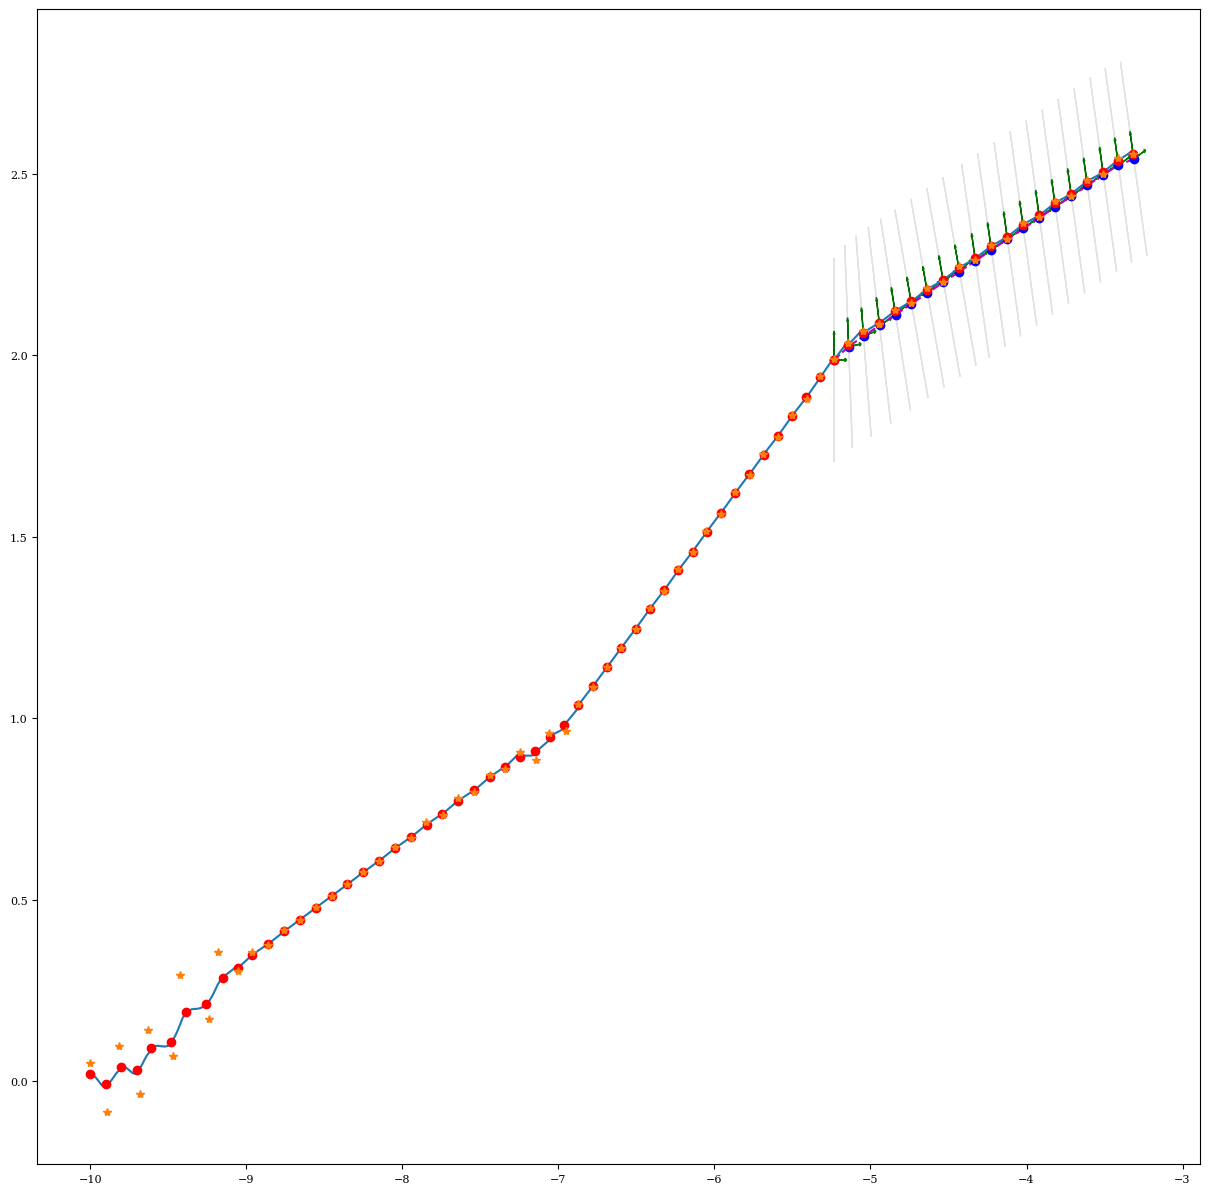

In [44]:
all_sag = np.array([])
all_lat = np.array([])
body_x_axis = np.array([])
body_y_axis = np.array([])

xhat = np.array([0.07, 0])
yhat = np.array([0, 0.07])

for i in range(len(robot.history["sagittal"])):
    
    sag = robot.history["sagittal"][i]
    lat = robot.history["lateral"][i]
    wp_x, wp_y, heading = robot.history["frame"][i]
    
    sag_global = np.array(sag) *np.cos(heading) - np.array(lat) *np.sin(heading) + wp_x
    lat_global = np.array(sag) *np.sin(heading) + np.array(lat) *np.cos(heading) + wp_y
    
    all_sag = np.append(all_sag,sag_global)
    all_lat = np.append(all_lat,lat_global)
    
    # Rotation matrix
    rotation = np.array([
    [np.cos(heading), -np.sin(heading)], 
    [np.sin(heading),  np.cos(heading)]])
    
    if i == 0:
        body_x_axis = np.append(body_x_axis, rotation.dot(xhat))
        body_y_axis = np.append(body_y_axis, rotation.dot(yhat))
    else:
        body_x_axis = np.vstack([body_x_axis, rotation.dot(xhat)])
        body_y_axis = np.vstack([body_y_axis, rotation.dot(yhat)])
        
all_wp_x = np.array(robot.history["waypoint_track"])[:,0]
all_wp_y = np.array(robot.history["waypoint_track"])[:,1]


plt.figure(figsize=(15,15))  
plt.plot(all_wp_x,all_wp_y, "m--")
plt.plot(all_wp_x,all_wp_y, "bo", label="Desired waypoint")
plt.plot(all_sag, all_lat, label="trajectory")
plt.plot(np.array(robot.history["apex_state"])[:,0], np.array(robot.history["apex_state"])[:,1], "or", label="return apex state")
plt.plot(np.array(robot.history["foot_position"])[:,0], np.array(robot.history["foot_position"])[:,1], "*", label="foot position")


# Draw body frame axes
for i in range(len(body_x_axis)):
    plt.arrow(all_wp_x[i], all_wp_y[i],  *body_x_axis[i], head_width=0.01, head_length=0.01, fc='g', ec='g')
    plt.arrow(all_wp_x[i], all_wp_y[i],  *body_y_axis[i], head_width=0.01, head_length=0.01, fc='g', ec='g')
    plt.arrow(all_wp_x[i], all_wp_y[i],  *-4*body_y_axis[i], head_width=0.001, head_length=0.001, fc='k', ec='k', alpha=0.1)
    plt.arrow(all_wp_x[i], all_wp_y[i],  *4*body_y_axis[i], head_width=0.001, head_length=0.001, fc='k', ec='k', alpha=0.1)


plt.grid()
plt.legend()

In [25]:
print("New collect sample X: ", x_new)
print("New collect observation: ", y_new)
robot.goals

New collect sample X:  [[ -7.59906388   2.66639698]
 [ -7.02337389  -0.67953544]
 [ -8.17685118   2.60294322]
 [ -9.41763421   2.35868084]
 [-10.37156735   2.92703936]
 [-10.43713505   2.09938805]
 [ -9.87307366  -1.95635696]
 [-10.00980242  -1.9671282 ]
 [ -7.02109338   1.3182424 ]
 [ -8.88652024  -2.58741086]
 [ -9.15624159   2.1751814 ]
 [ -9.33457631   3.01717518]
 [-10.97116284   0.11394494]
 [ -7.9551219   -2.57895878]
 [ -7.0663782   -1.08404575]
 [ -8.25078746   2.73860352]
 [ -9.34504247  -1.61765958]
 [-10.11035437   2.43619239]
 [ -7.4619145    0.60686954]
 [ -7.34173938   1.78981144]
 [ -6.71078296   0.60213488]
 [-10.80563896  -2.56934941]
 [-10.37601187   0.32765523]
 [ -7.61060114  -2.40876705]
 [ -8.37614964   1.16643379]
 [ -7.93425244   2.26319239]
 [ -8.59025526  -0.20258965]
 [ -7.60907063   0.49736669]
 [ -6.94223294  -2.80679156]
 [ -7.08659376   1.21428331]
 [ -7.26226037   1.17584729]
 [ -6.94637055  -2.4740392 ]
 [ -7.92643102  -1.84818256]
 [ -8.22809124  -0.3

array([], shape=(0, 2), dtype=float64)

In [26]:
print("training x size", model.train_x.shape)
print("training y size",model.train_y.shape)

training x size torch.Size([130, 2])
training y size torch.Size([130])


In [27]:
model.add_data(x_new, y_new)
print("training x size", model.train_x.shape)
print("training y size",model.train_y.shape)

evaluator.add_data(x_new, y_new) #set training data
model_update(cfg.num_train_steps, model, evaluator)
print("losses", evaluator.losses)
print("training time", evaluator.training_times)

evaluation(model, evaluator)
print("num_samples", evaluator.num_samples)
print("training_times", evaluator.training_times)


training x size torch.Size([197, 2])
training y size torch.Size([197])
losses [1.337920130512261, 1.335513691826368, 1.333116765084214, 1.3307298135275158, 1.3283532930060715, 1.3259876400338828, 1.3236332695756479, 1.3212905722522919, 1.3189599112139303, 1.3166416195085173, 1.2900544228333055, 1.2878978533951957, 1.2857590250126758, 1.2836370264388395, 1.281531172329859, 1.2794409465247008, 1.2773659622706208, 1.275305933623545, 1.2732606544211762, 1.2712299824221165, 1.212003124054013, 1.2098964179873855, 1.2077948136938115, 1.2056993684396218, 1.2036109886833823, 1.2015304624516012, 1.1994584835991302, 1.1973956702637707, 1.195342579047961, 1.1932997161185621]
training time [1.8814740180969238, 0.0714111328125, 0.1553492546081543]
num_samples [100, 130, 197]
training_times [1.8814740180969238, 0.0714111328125, 0.1553492546081543]


(-11.0, -9.0, 11.0, 9.0)

In [31]:
#scale back to actual elevation value
y_scaler.postprocess_mean(model.train_y)

tensor([[ 0.1238,  0.2816,  0.3835,  0.3956,  0.2427,  0.1699,  0.2937,  0.4248,
          0.2694,  0.1408,  0.1505,  0.2573,  0.3058,  0.1675,  0.1165,  0.2549,
          0.3034,  0.3374,  0.1262,  0.2961,  0.1286,  0.1214,  0.1335,  0.3252,
          0.3665,  0.2233,  0.1917,  0.1820,  0.2549,  0.1578,  0.1068,  0.1432,
          0.1699,  0.2670,  0.1917,  0.2451,  0.3155,  0.4126,  0.4369,  0.4563,
          0.0874,  0.1286,  0.2209,  0.3107,  0.2913,  0.2379,  0.3883,  0.4733,
          0.3398,  0.3835,  0.0680,  0.0898,  0.1869,  0.2500,  0.3325,  0.2816,
          0.3592,  0.2961,  0.3083,  0.3665,  0.0510,  0.1481,  0.1820,  0.2985,
          0.2524,  0.2282,  0.3350,  0.2549,  0.3350,  0.3519,  0.0947,  0.1189,
          0.2209,  0.2476,  0.2621,  0.2112,  0.3252,  0.2039,  0.3010,  0.3908,
          0.0631,  0.1262,  0.1553,  0.2209,  0.2476,  0.1481,  0.2379,  0.2840,
          0.2573,  0.2573,  0.0485,  0.0243,  0.0316,  0.2573,  0.2403,  0.0364,
          0.1529,  0.0971,  

In [ ]:
evaluation(model, evaluator)

print("smses", evaluator.smses)
print("rmses", evaluator.rmses)
print("maes", evaluator.maes)
print("mslls", evaluator.mslls)
print("nlpds", evaluator.nlpds)

In [ ]:
decision_epoch = 0
start_time = time()
time_elapsed = time() - start_time
decision_epoch += 1
visualizer.plot_title(decision_epoch, time_elapsed)
x_new, y_new = information_gathering(robot, model, planner, samples_per_dt=10, visualizer=visualizer)
evaluator.add_data(x_new, y_new)
model.add_data(x_new, y_new)
model_update(cfg.num_train_steps, model, evaluator)
evaluation(model, evaluator)
visualizer.clear()
if cfg.kernel.name == "AK":
    visualizer.plot_lengthscales(
        model, evaluator, cfg.kernel.min_lengthscale, cfg.kernel.max_lengthscale
    )
visualization(visualizer, evaluator)
visualizer.pause()

In [ ]:
visualizer.show()